# 0.0 IMPORTS

In [37]:
import math
import pickle
import inflection
import warnings
import datetime

import numpy    as np
import pandas   as pd
import seaborn  as sns
import xgboost  as xgb
import lightgbm as lgbm

from random                import sample
#from boruta                import BorutaPy
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## 0.1 Helper Functions

In [44]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return  np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])


def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)


def cross_validation(x_training, kfold, model_name, model, verbose=1):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold+1)):
        if verbose == 1 or verbose == 2:
            print('\nKFold Number: {}'.format(k))
            
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # Feature engineering
        rs = RobustScaler()
        mms = MinMaxScaler()

        # competition distance
        training['competition_distance'] = rs.fit_transform(training[['competition_distance']].values)
        validation['competition_distance'] = rs.transform(validation[['competition_distance']].values)

        # competition time month
        training['competition_time_month'] = rs.fit_transform(training[['competition_time_month']].values)
        validation['competition_time_month'] = rs.transform(validation[['competition_time_month']].values)

        # promo time week
        training['promo_time_week'] = mms.fit_transform(training[['promo_time_week']].values)
        validation['promo_time_week'] = mms.transform(validation[['promo_time_week']].values)

        # year
        training['year'] = mms.fit_transform(training[['year']].values)
        validation['year'] = mms.transform(validation[['year']].values)

        # state_holiday - One Hot Encoding
        # one hot encoding
        ohe = OneHotEncoder()        
        transformed = ohe.fit_transform(training[['state_holiday']])
        training[ohe.categories_[0]] = transformed.toarray()

        # tranform encoding for test data
        transformed_valid = ohe.transform(validation[['state_holiday']])
        validation[ohe.categories_[0]] = transformed_valid.toarray()

        # store_type - Label Encoding
        le = LabelEncoder()
        training['store_type'] = le.fit_transform(training['store'])
        validation['store_type'] = le.transform(validation['store'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        training['assortment'] = training['assortment'].map(assortment_dict)
        validation['assortment'] = validation['assortment'].map(assortment_dict)

        # Response Variable Transformation
        training['sales'] = np.log1p(training['sales'])
        validation['sales'] = np.log1p(validation['sales'])

        # day of week
        training['day_of_week_sin'] = training['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        training['day_of_week_cos'] = training['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        validation['day_of_week_sin'] = validation['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        validation['day_of_week_cos'] = validation['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        training['month_sin'] = training['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        training['month_cos'] = training['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        validation['month_sin'] = validation['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        validation['month_cos'] = validation['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        training['day_sin'] = training['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        training['day_cos'] = training['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        validation['day_sin'] = validation['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        validation['day_cos'] = validation['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week of year
        training['week_of_year_sin'] = training['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        training['week_of_year_cos'] = training['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

        validation['week_of_year_sin'] = validation['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        validation['week_of_year_cos'] = validation['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

        cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
        training = training.drop(cols_drop, axis=1)
        validation = validation.drop(cols_drop, axis=1)

        if verbose == 2:
            print('End of Data Preparation')

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales', 'state_holiday'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales', 'state_holiday'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold interaction
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
        if verbose == 2:
            print('Iteration Done')
    
    return pd.DataFrame({'Model name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)},                               
                        index=[0])


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/matheus/.pyenv/versions/3.8.12/envs/dsemproducao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',             'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types


In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if 
                                                math.isnan(x['competition_open_since_month']) else
                                                x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if 
                                                math.isnan(x['competition_open_since_year']) else
                                                x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if 
                                                math.isnan(x['promo2_since_week']) else
                                                x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if 
                                                math.isnan(x['promo2_since_year']) else
                                                x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8:'Aug', 9:'Sept', 10: 'Oct', 
             11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in 
                                  x['promo_interval'].split(',') else 0, axis = 1)

## 1.6 Change Types

In [11]:
# competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

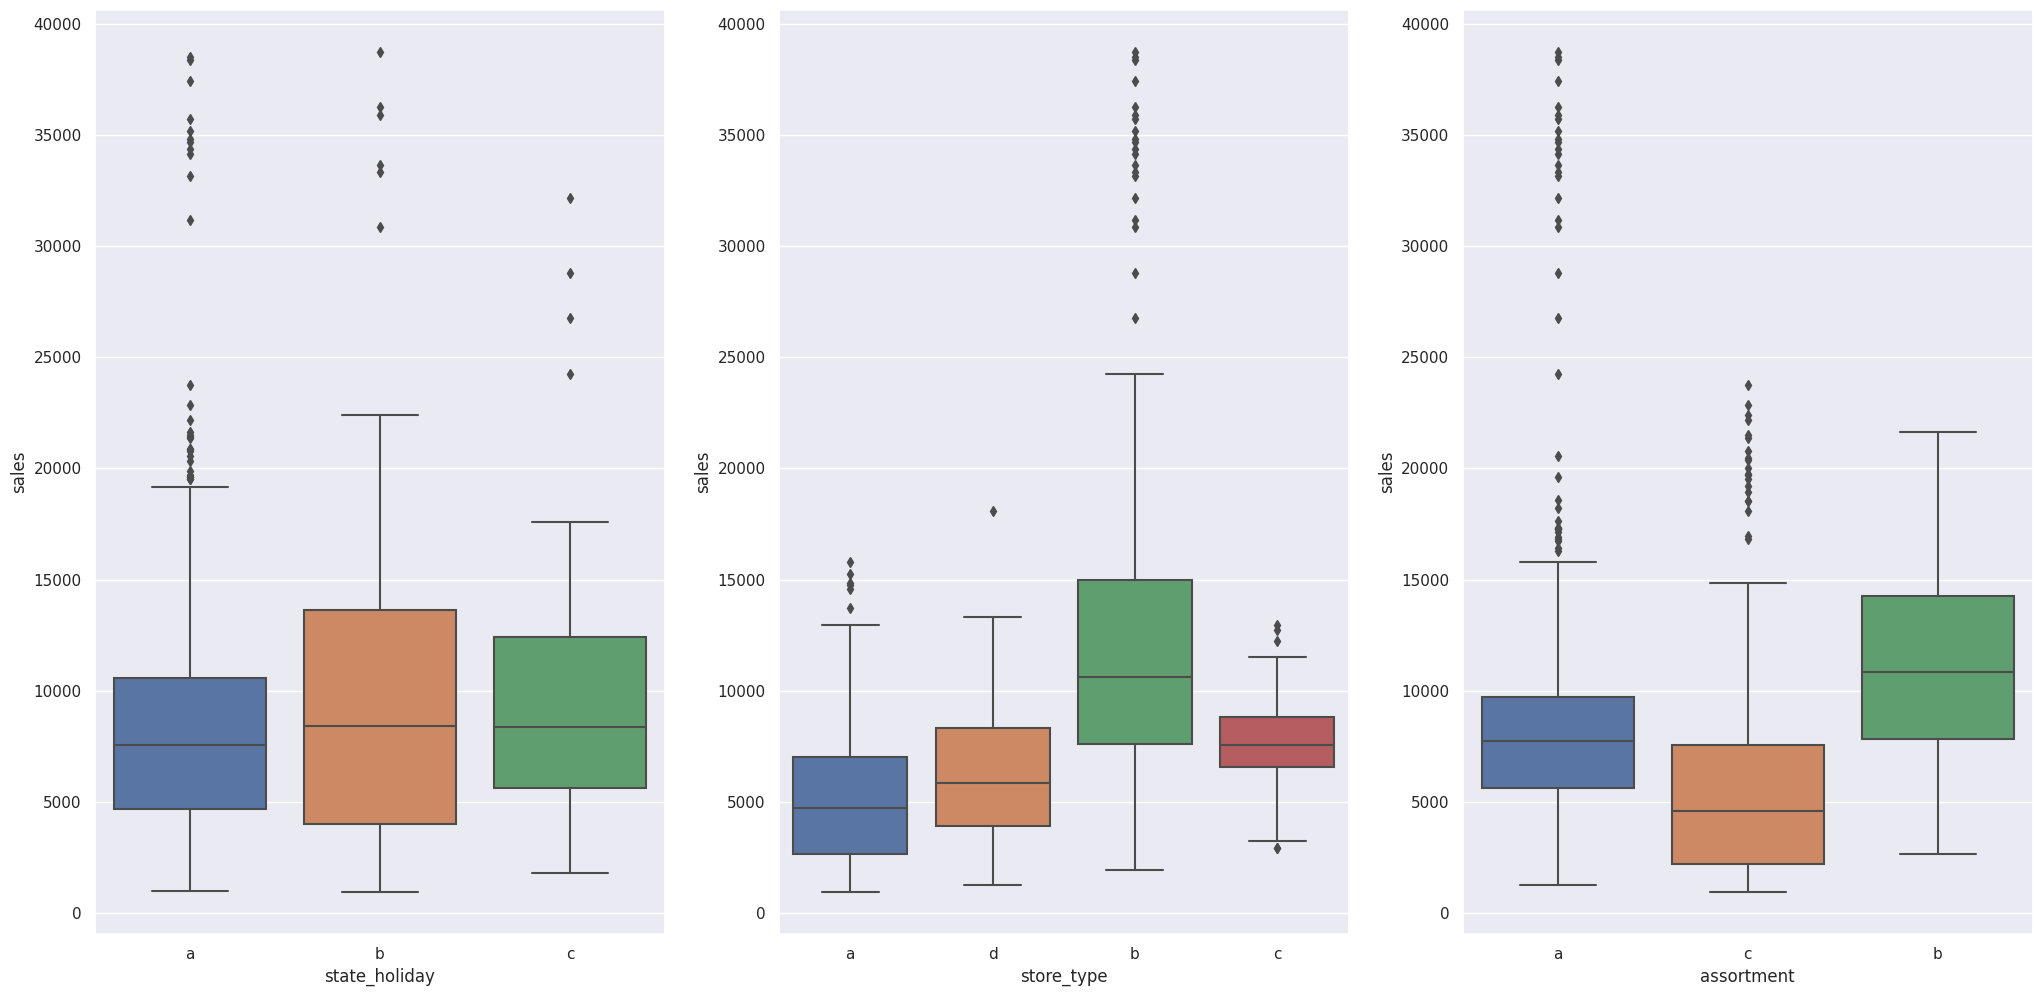

In [15]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

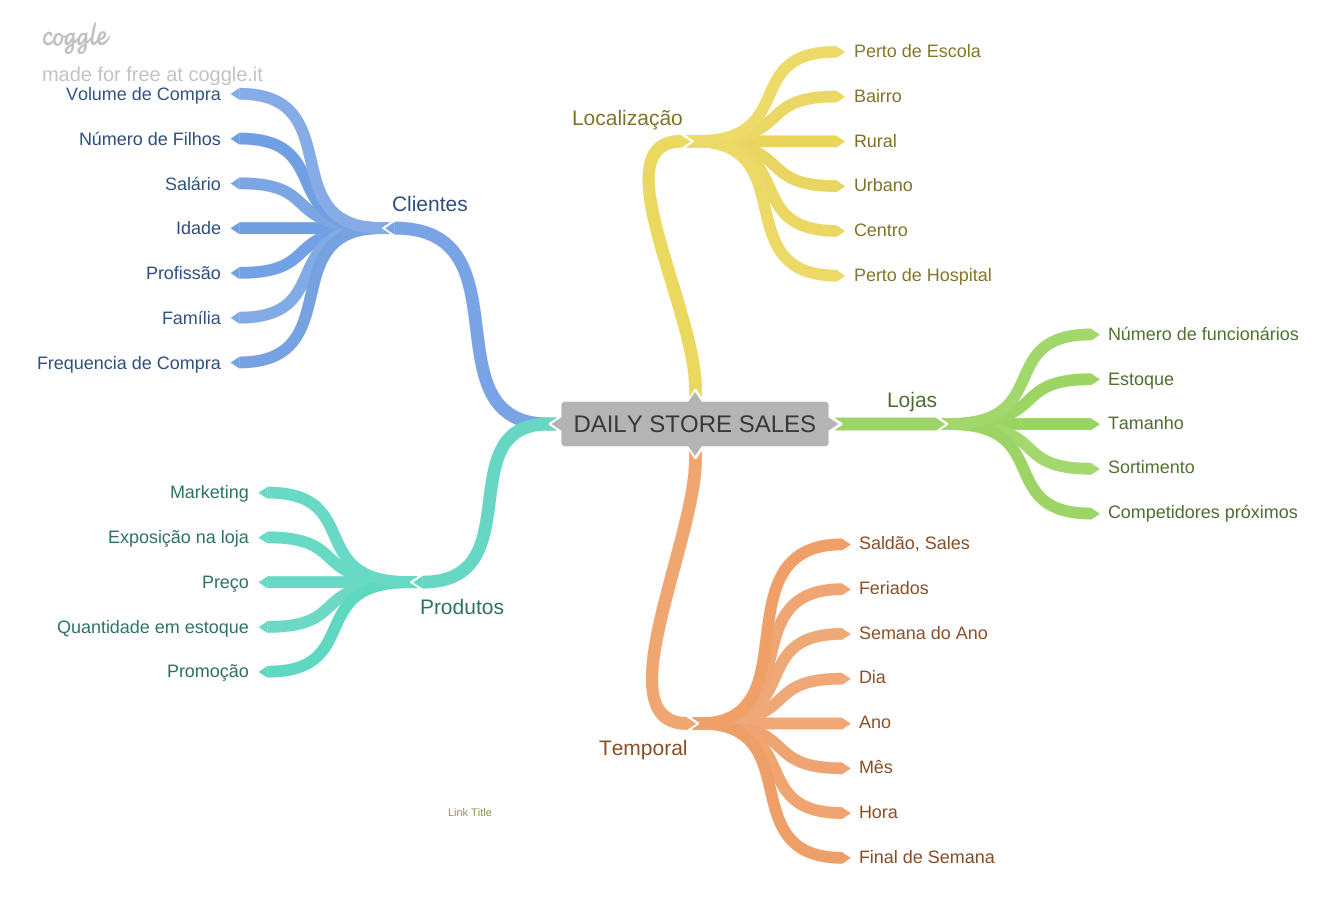

In [17]:
Image('../img/MindMapHypothesis.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.


**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.**  Lojas deveriam vender mais no segundo semestre do ano.

**10.**  Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.**  Lojas deveriam vender menos aos finais de semana.

**12.**  Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [18]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int) 

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' 
                                               else 'christmas' if x == 'c' else 'regular_day')

In [19]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 3 - FILTRAGEM DE VARIÁVEIS 

In [20]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas 

In [21]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas 

In [22]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [23]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [24]:
df4 = df3.copy()

## 4.1 Análise Univariada 

### 4.1.1 Response Variable

<AxesSubplot: xlabel='sales', ylabel='Density'>

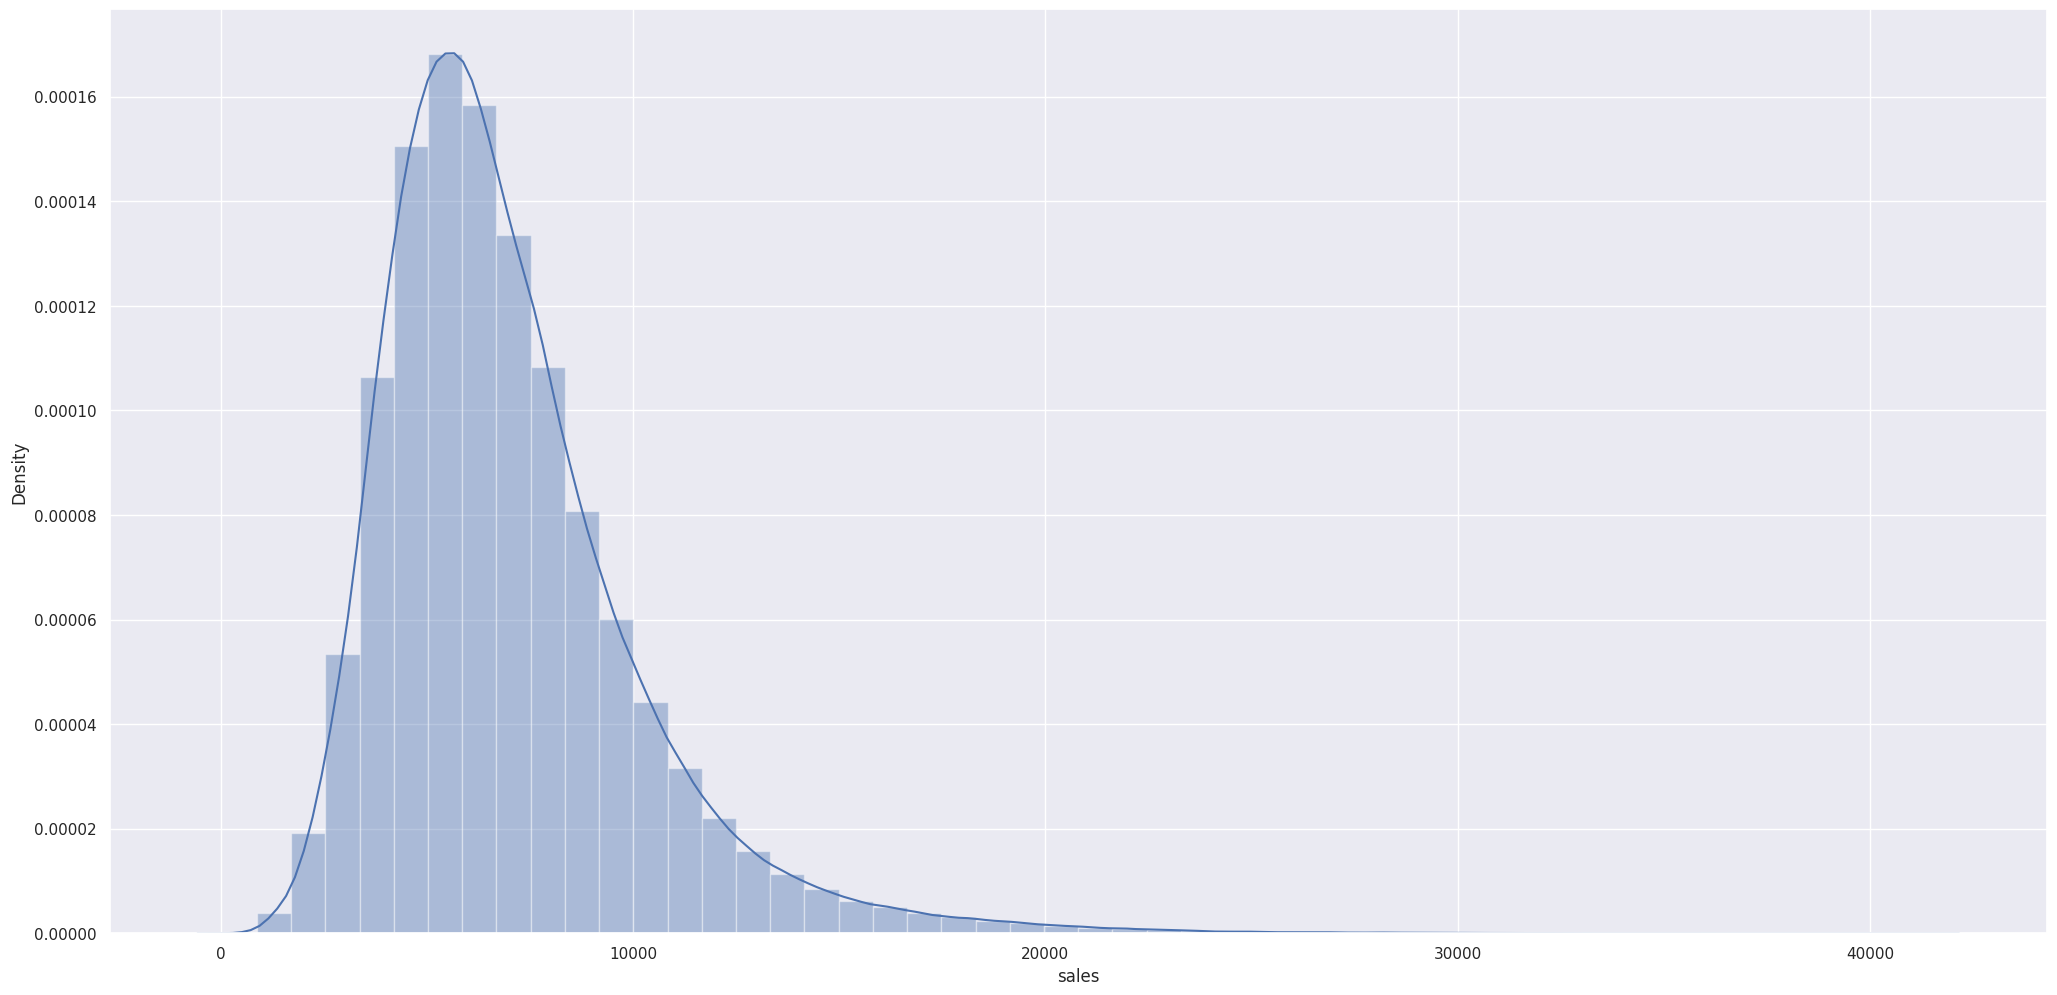

In [26]:
sns.distplot(df4['sales']) #kde=False para plotar histograma

### 4.1.2 Numerical Variable

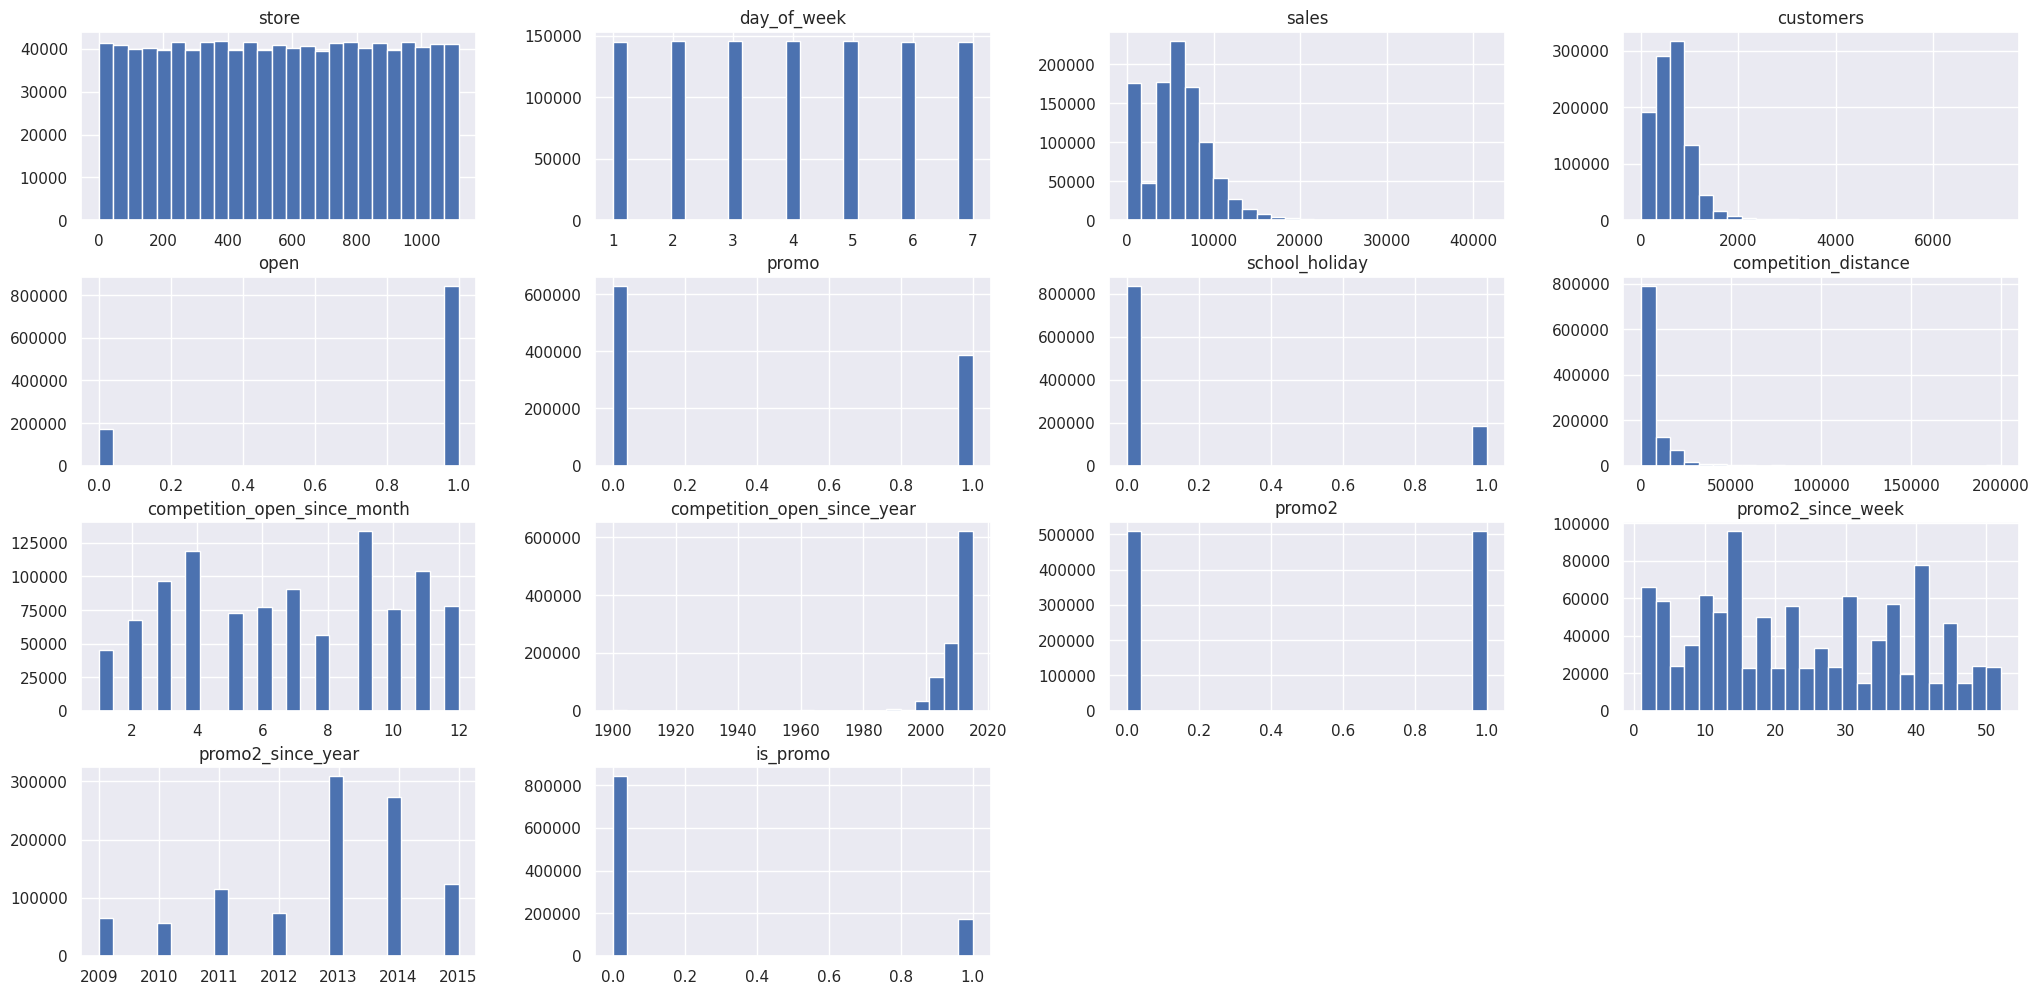

In [27]:
num_attributes.hist(bins=25);

### 4.1.1 Categorical Variable

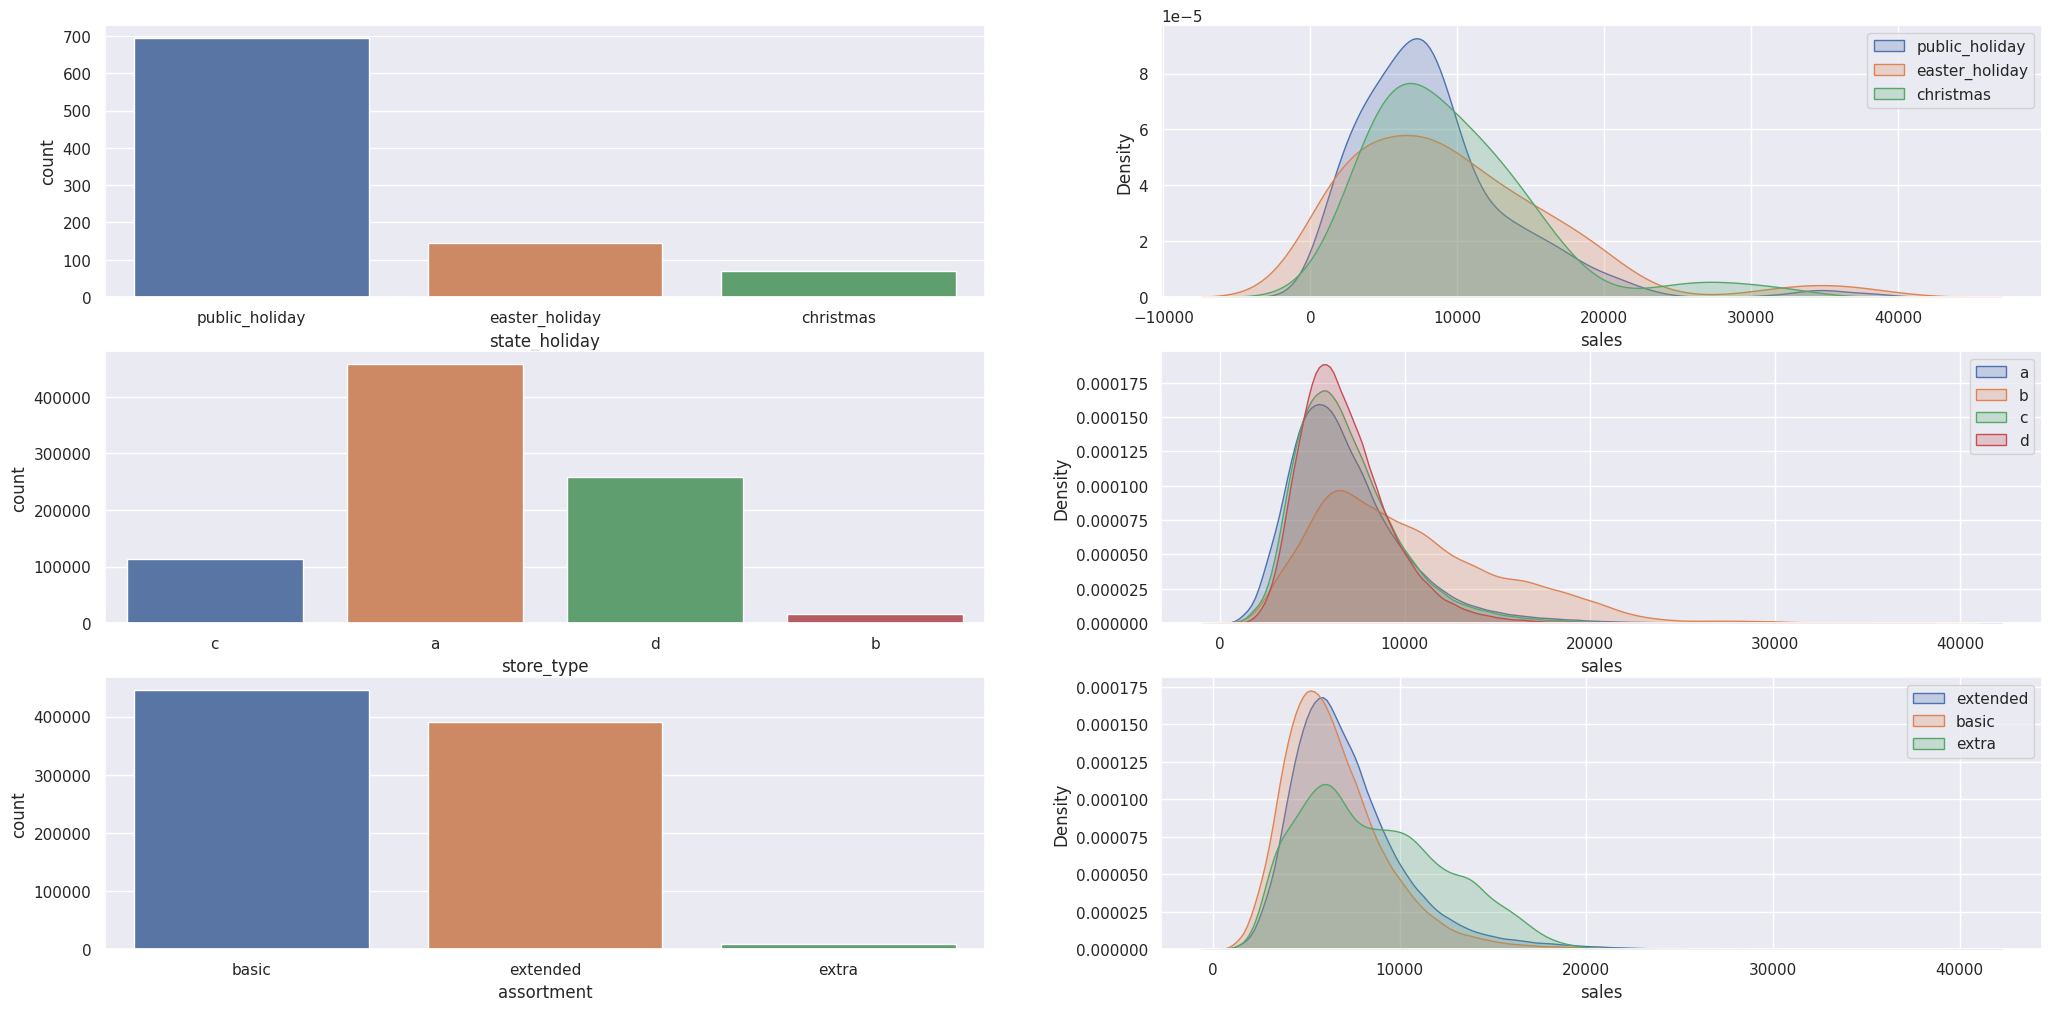

In [28]:
# state_holiday
plt.subplot(3, 2, 1)
ax = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=ax['state_holiday'])

plt.subplot(3, 2, 2)
ax1 = sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
ax1 = sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
ax1 = sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
ax1.legend(loc="upper right")

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x=df4['store_type'])

plt.subplot(3, 2, 4)
ax2 = sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
ax2 = sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
ax2 = sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
ax2 = sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
ax2.legend(loc="upper right")

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x=df4['assortment'])

plt.subplot(3, 2, 6)
ax3 = sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
ax3 = sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
ax3 = sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
ax3.legend(loc="upper right")

## 4.2 Análise Bivariada 

### H1. Lojas com maior sortimentos deveriam vender mais.
***FALSA.*** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot: xlabel='year_week'>

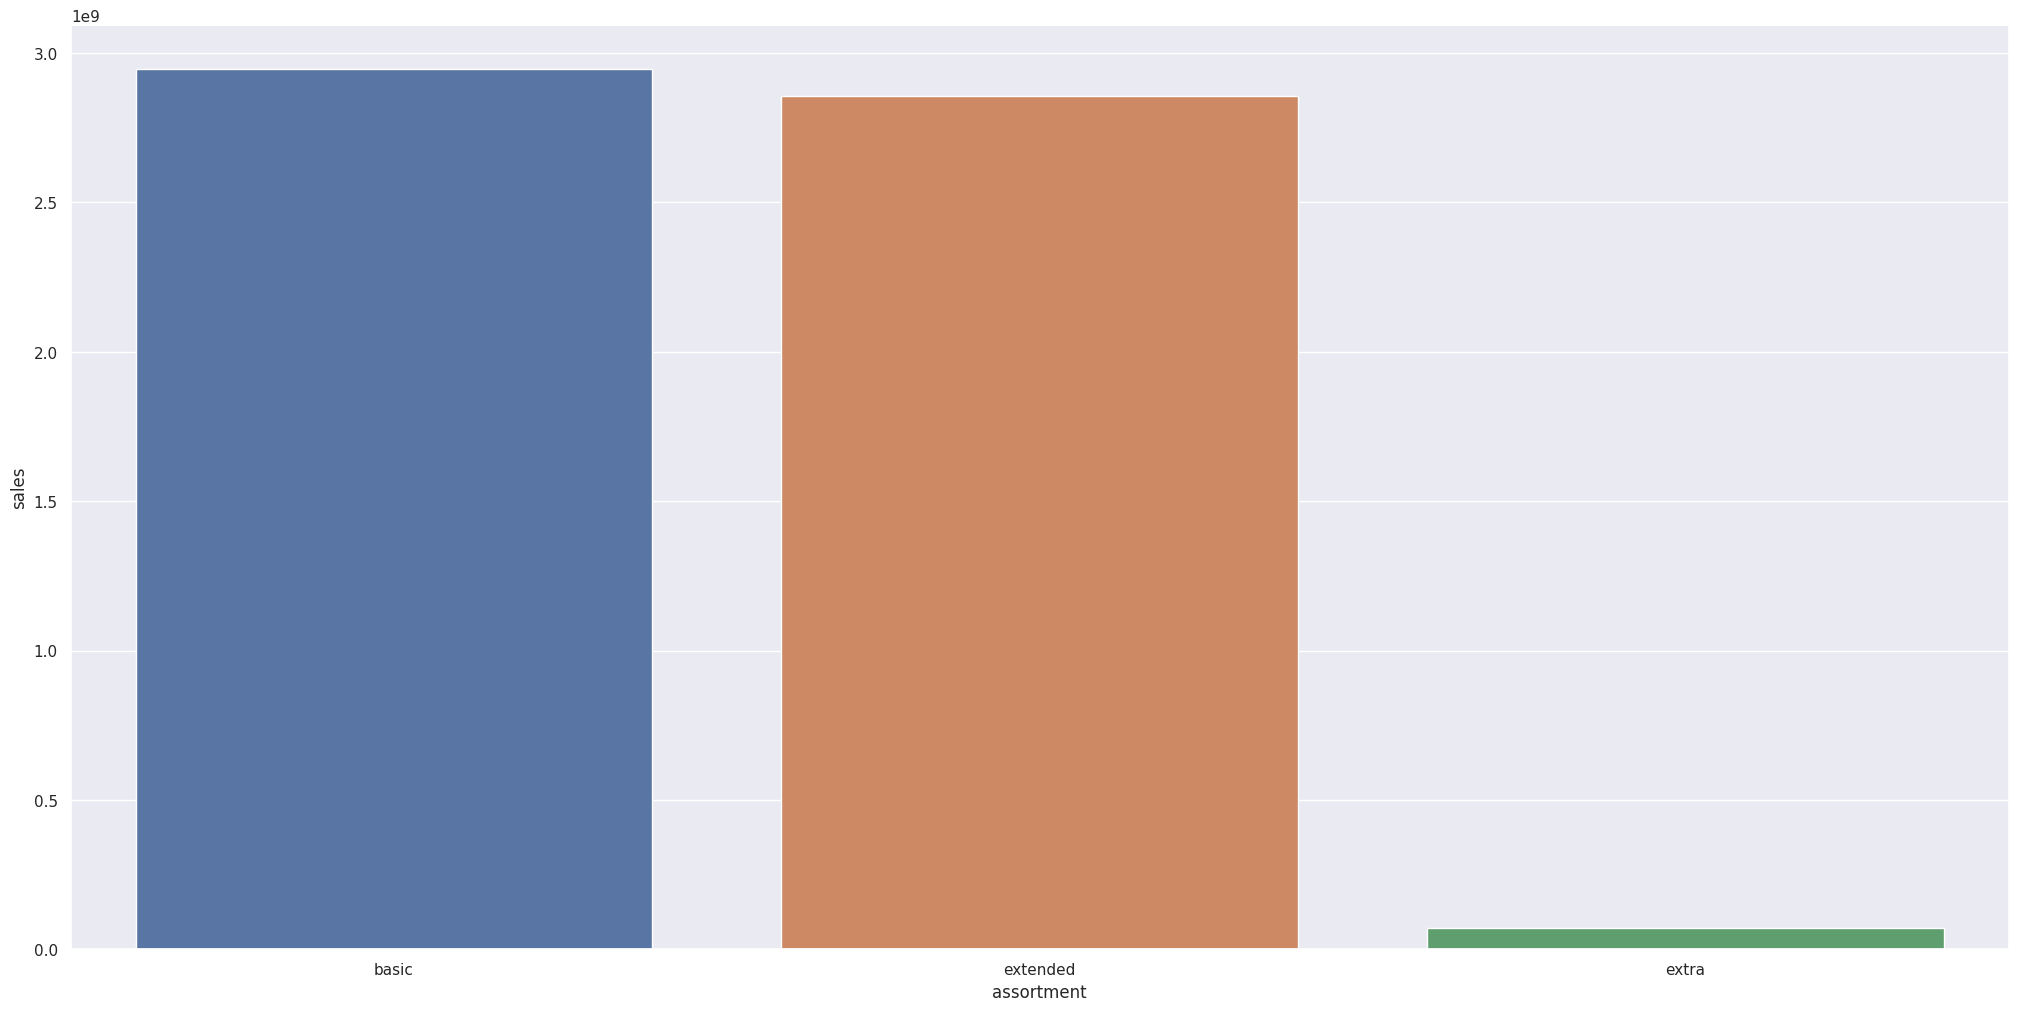

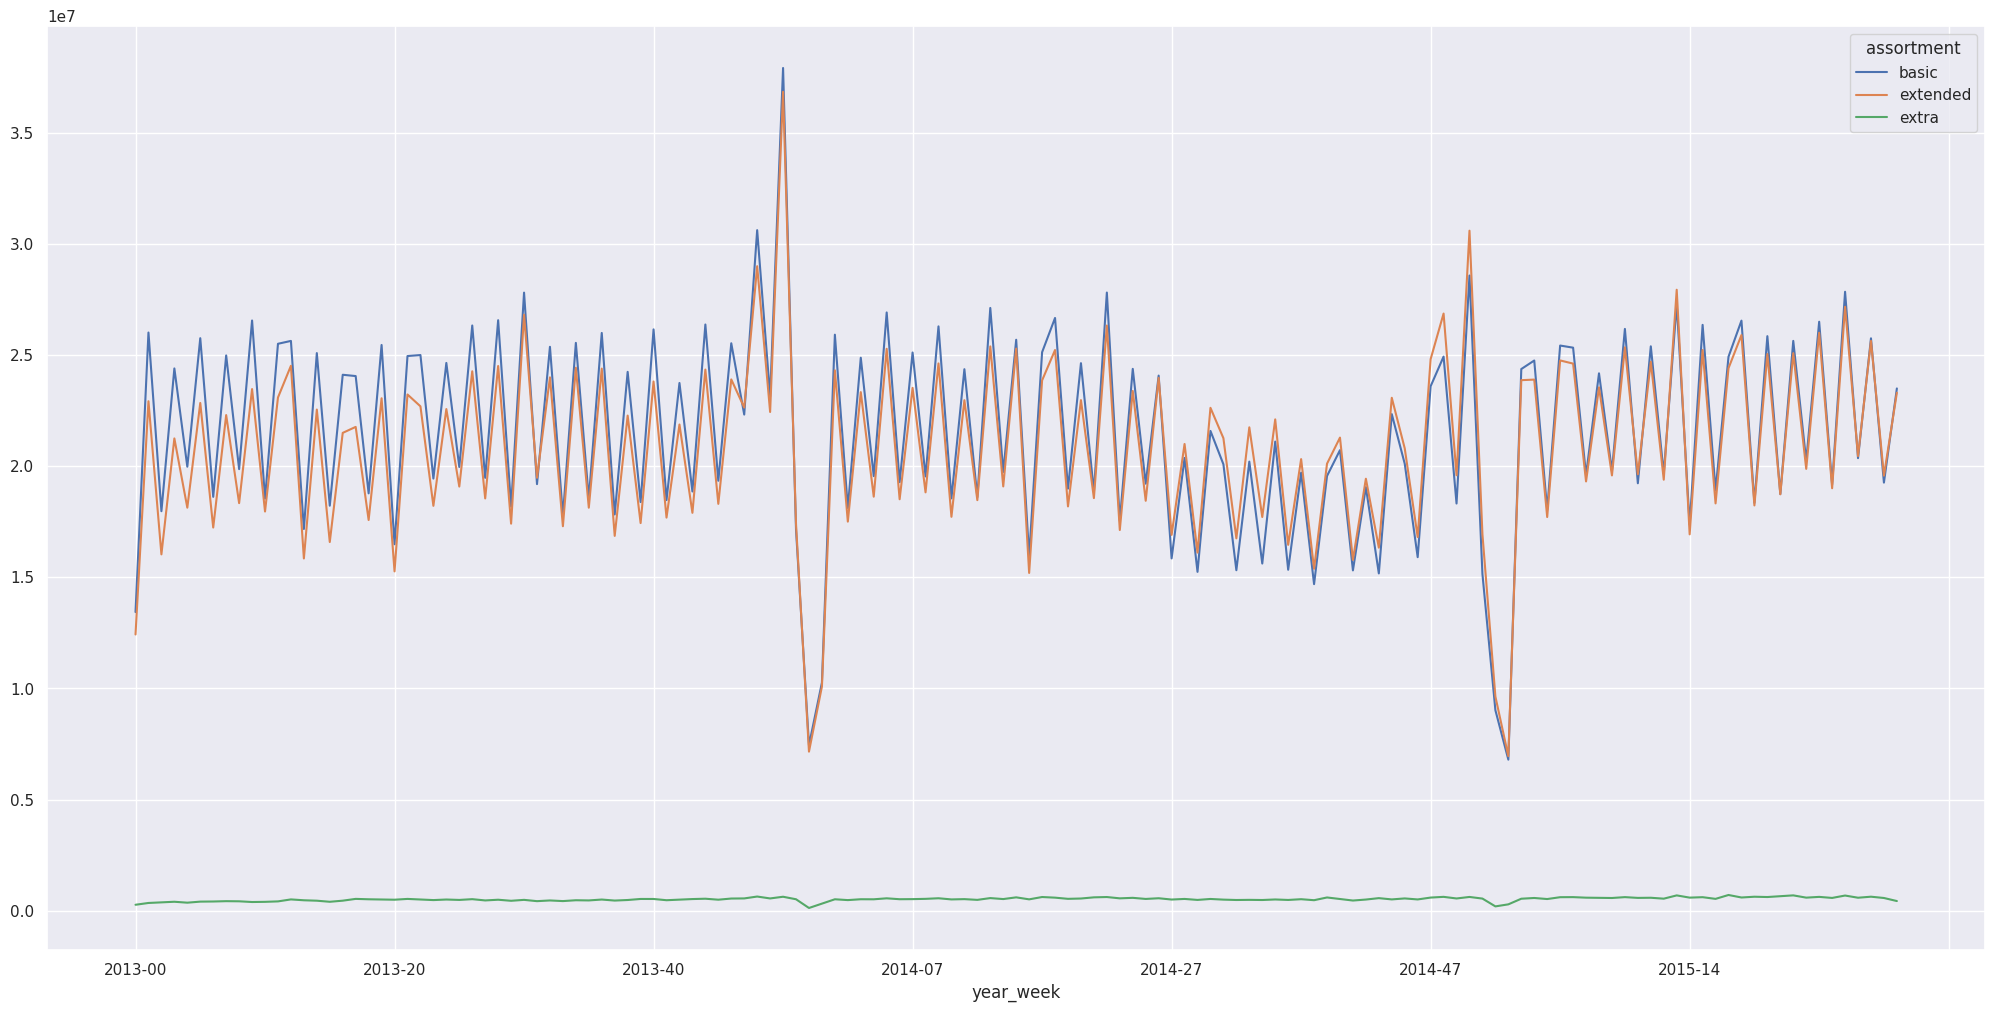

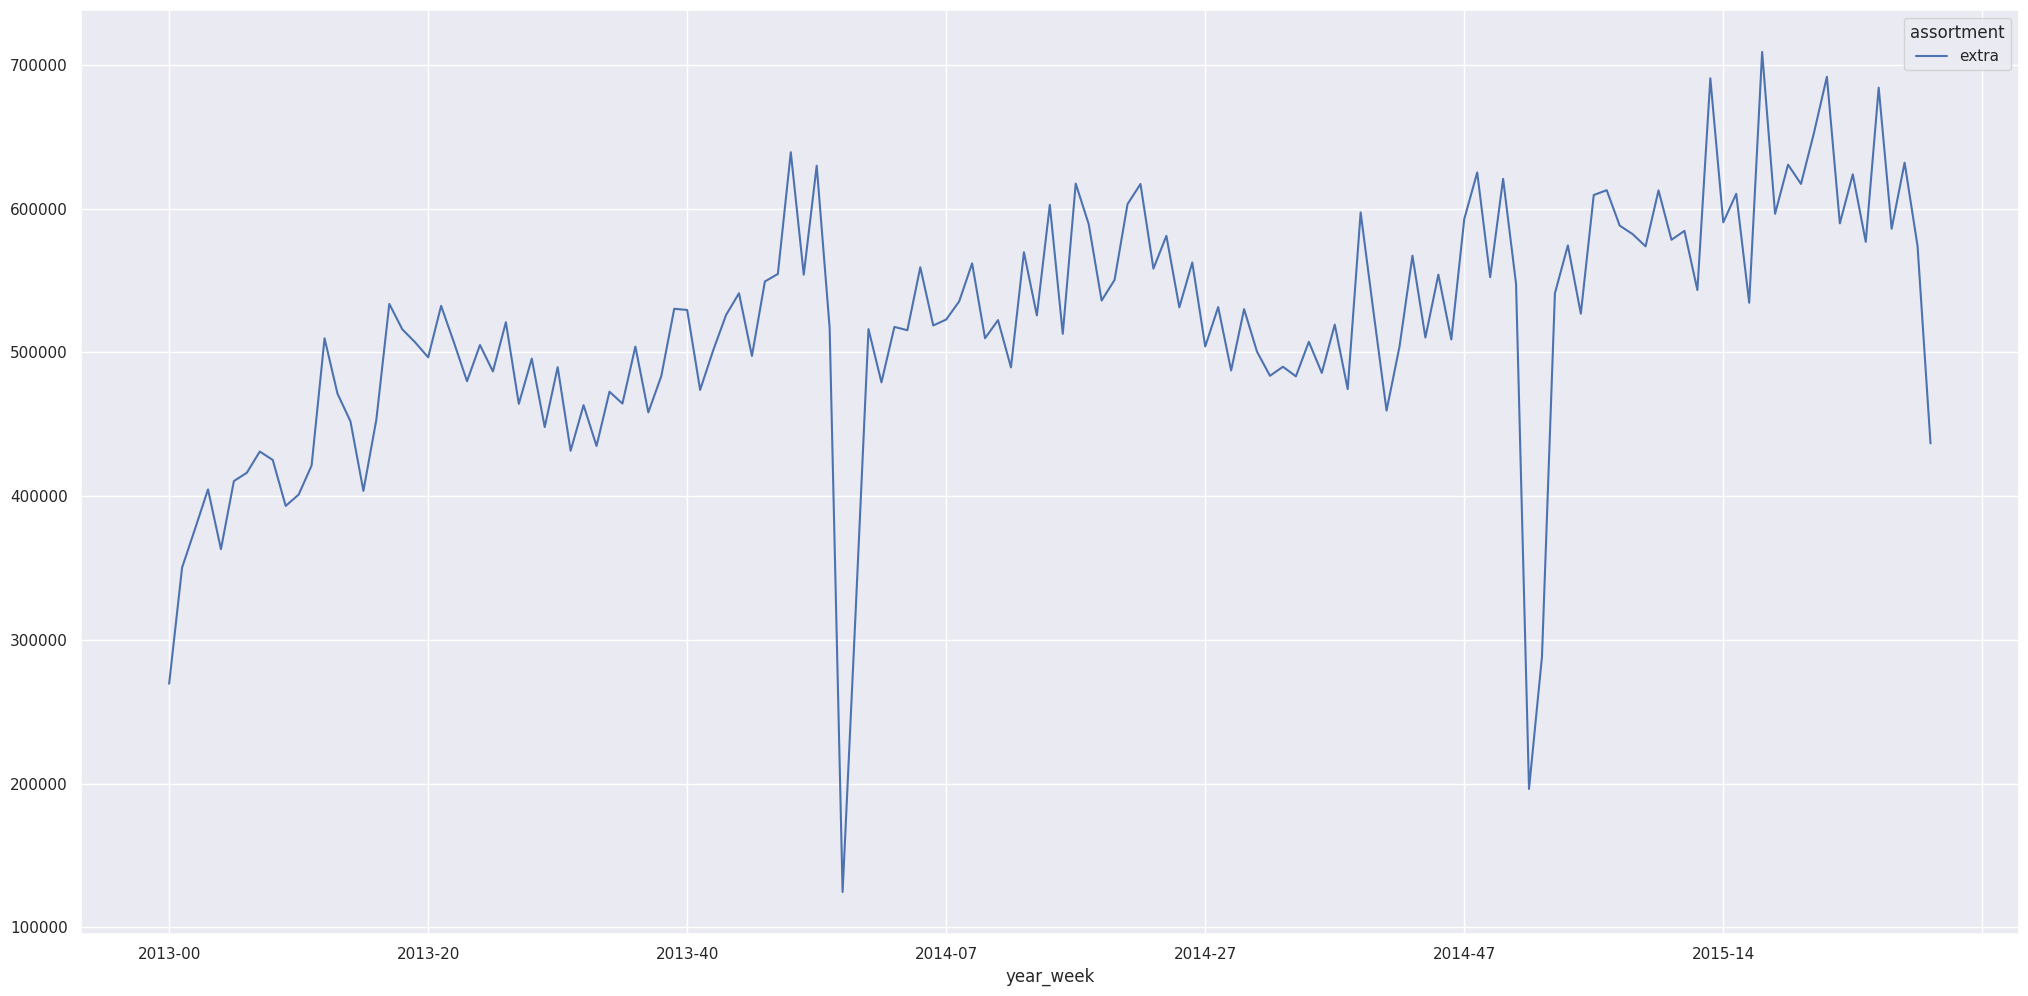

In [29]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(aux1, x='assortment', y='sales')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
***FALSA.*** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

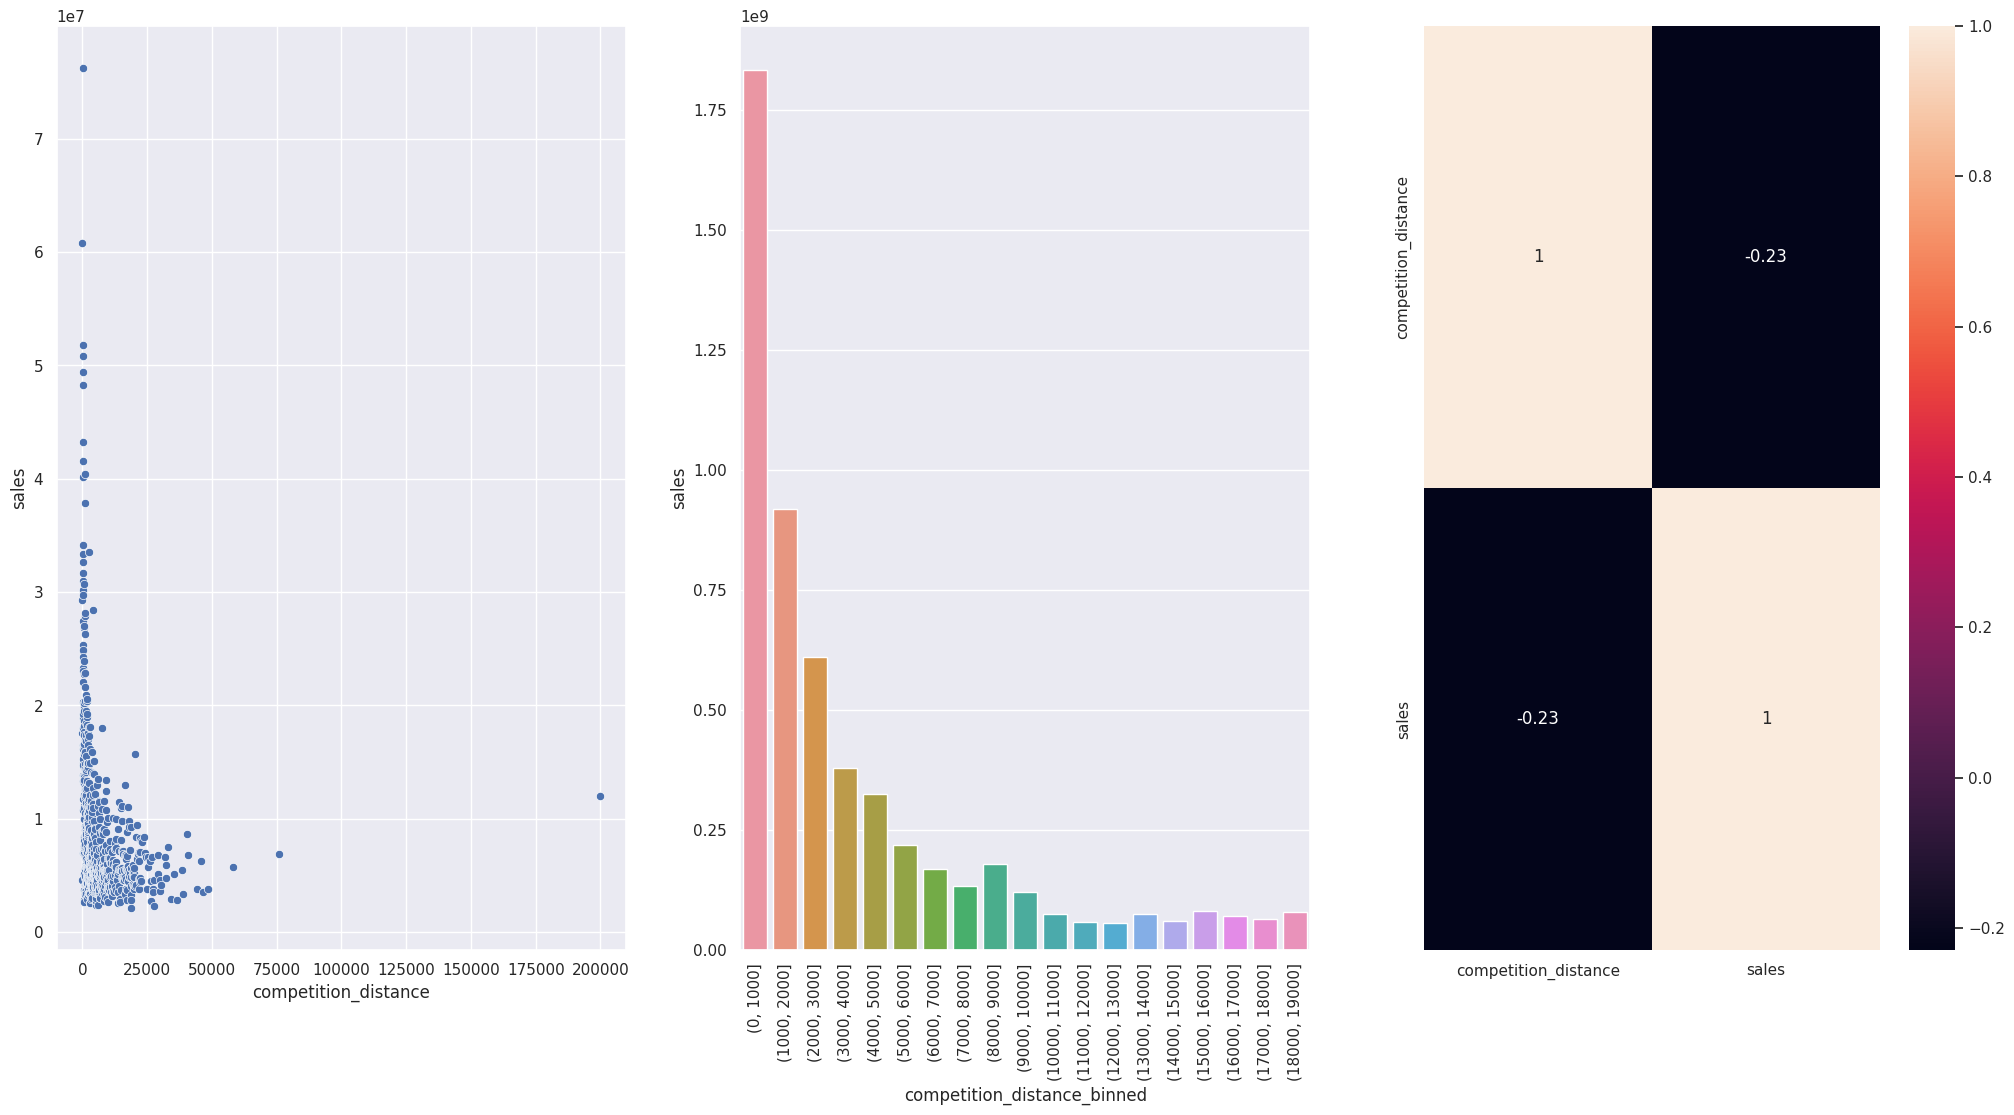

In [30]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(data=aux1, x='competition_distance', y='sales')

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.xticks(rotation=90)

sns.barplot(data=aux2, x='competition_distance_binned', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores à mais tempo deveriam vender mais.
***FALSA.*** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

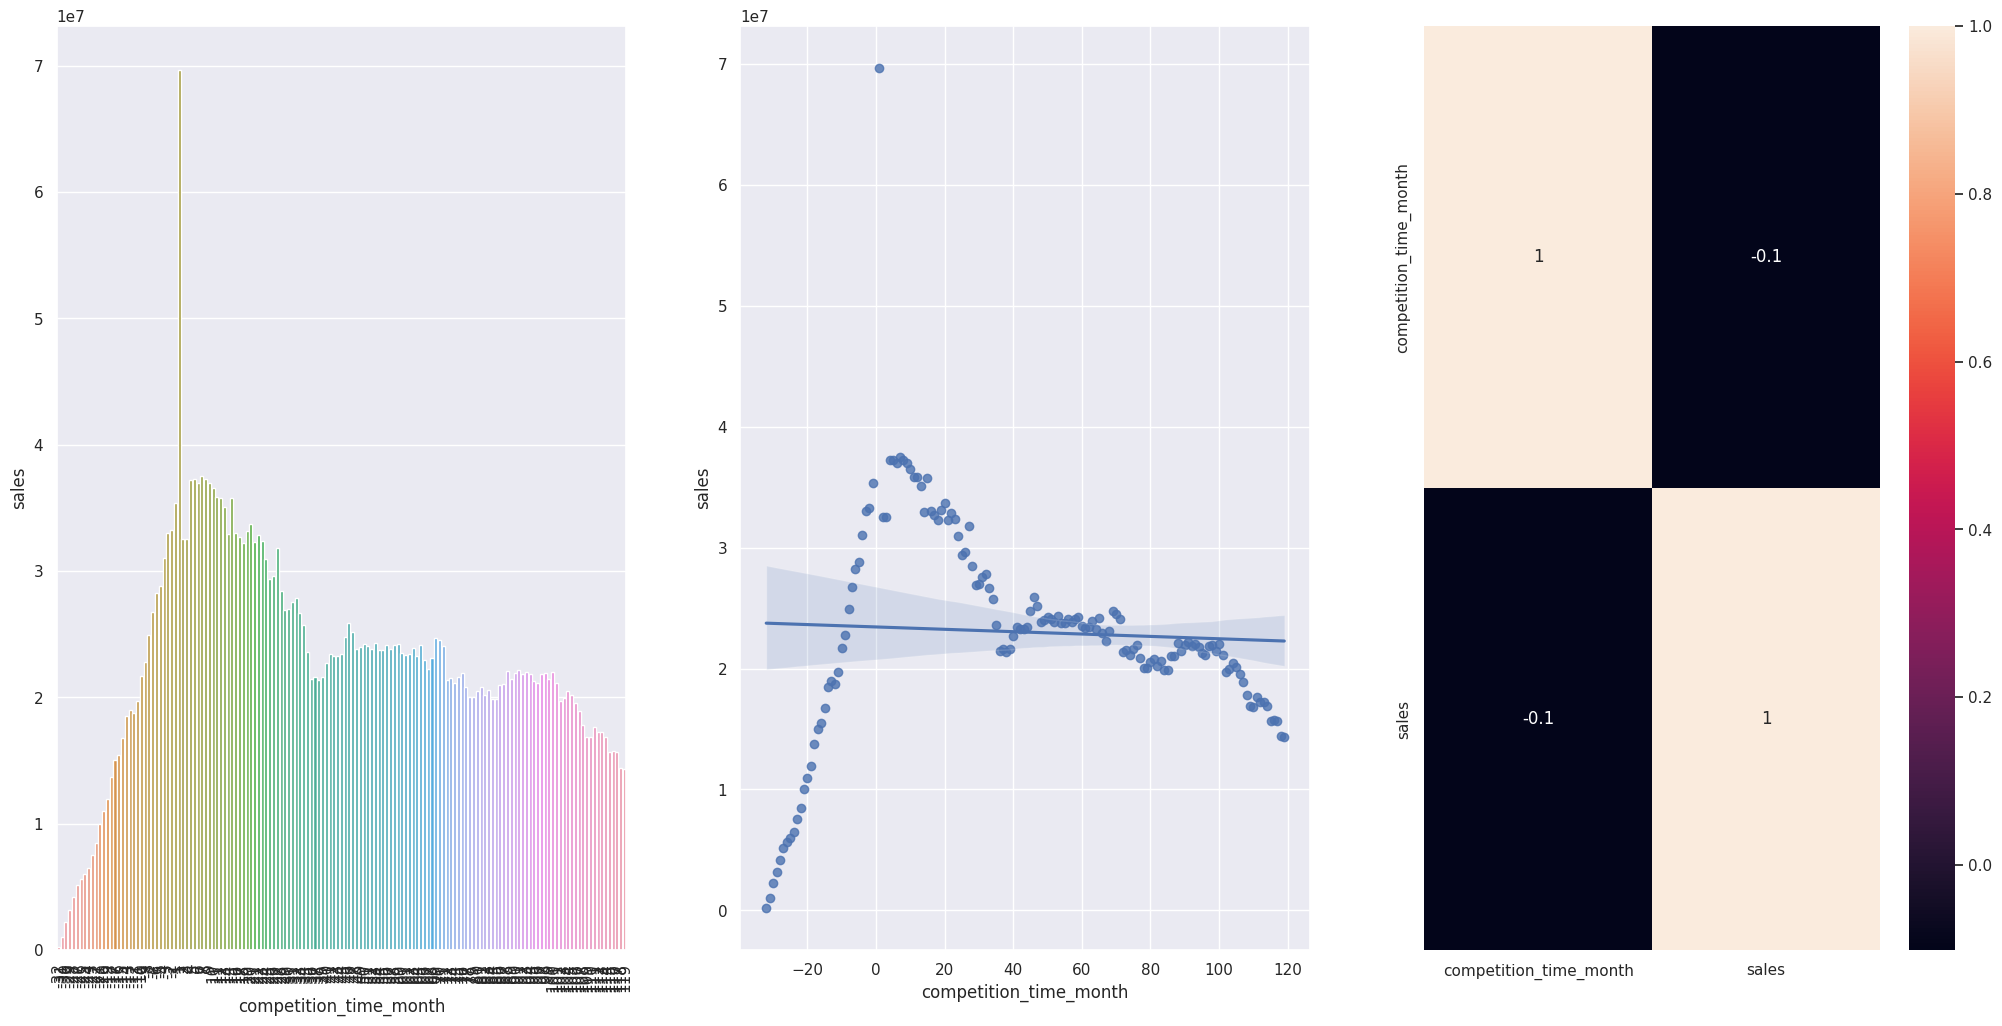

In [31]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
***FALSA.*** Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS, depois de um certo período de promoção.

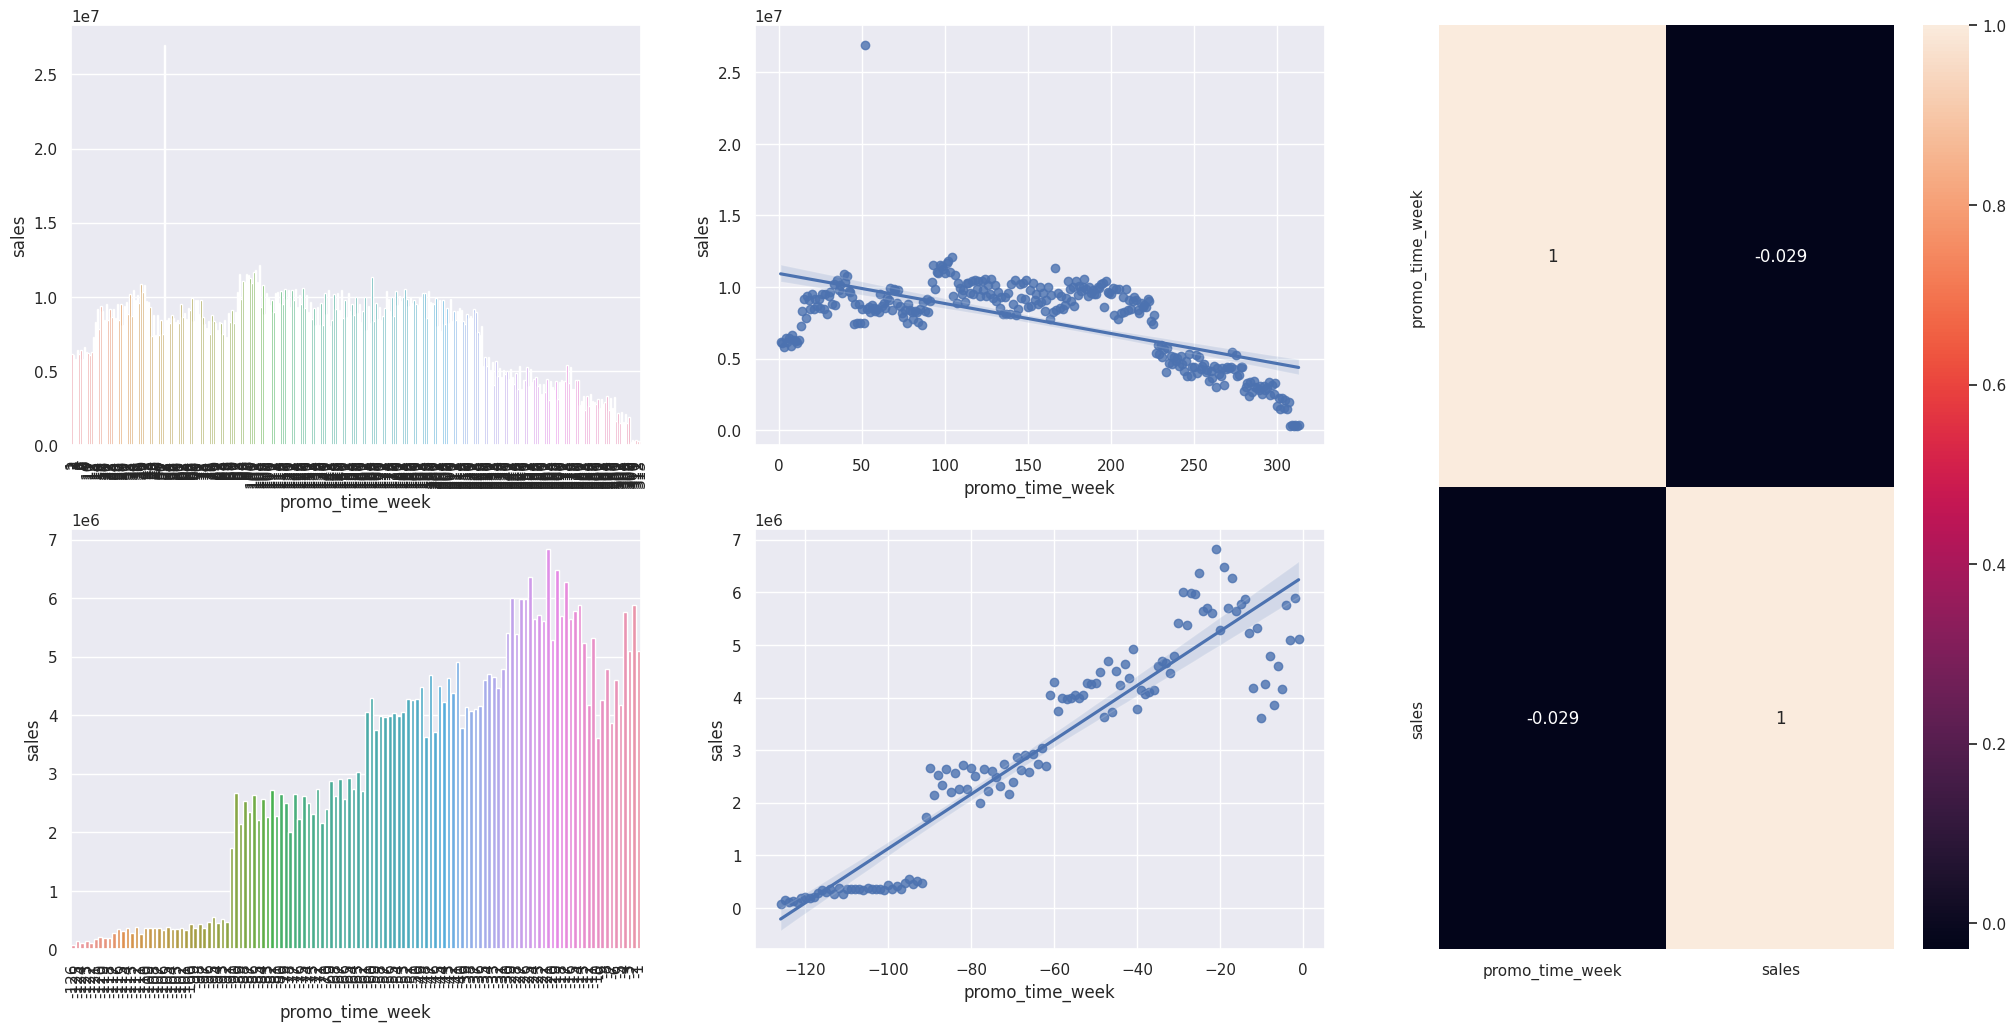

In [32]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5. Lojas com mais dias de promocão deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
***FALSA.*** Lojas com MAIS PROMOÇÕES CONSECUTIVAS vendem MENOS.

In [33]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


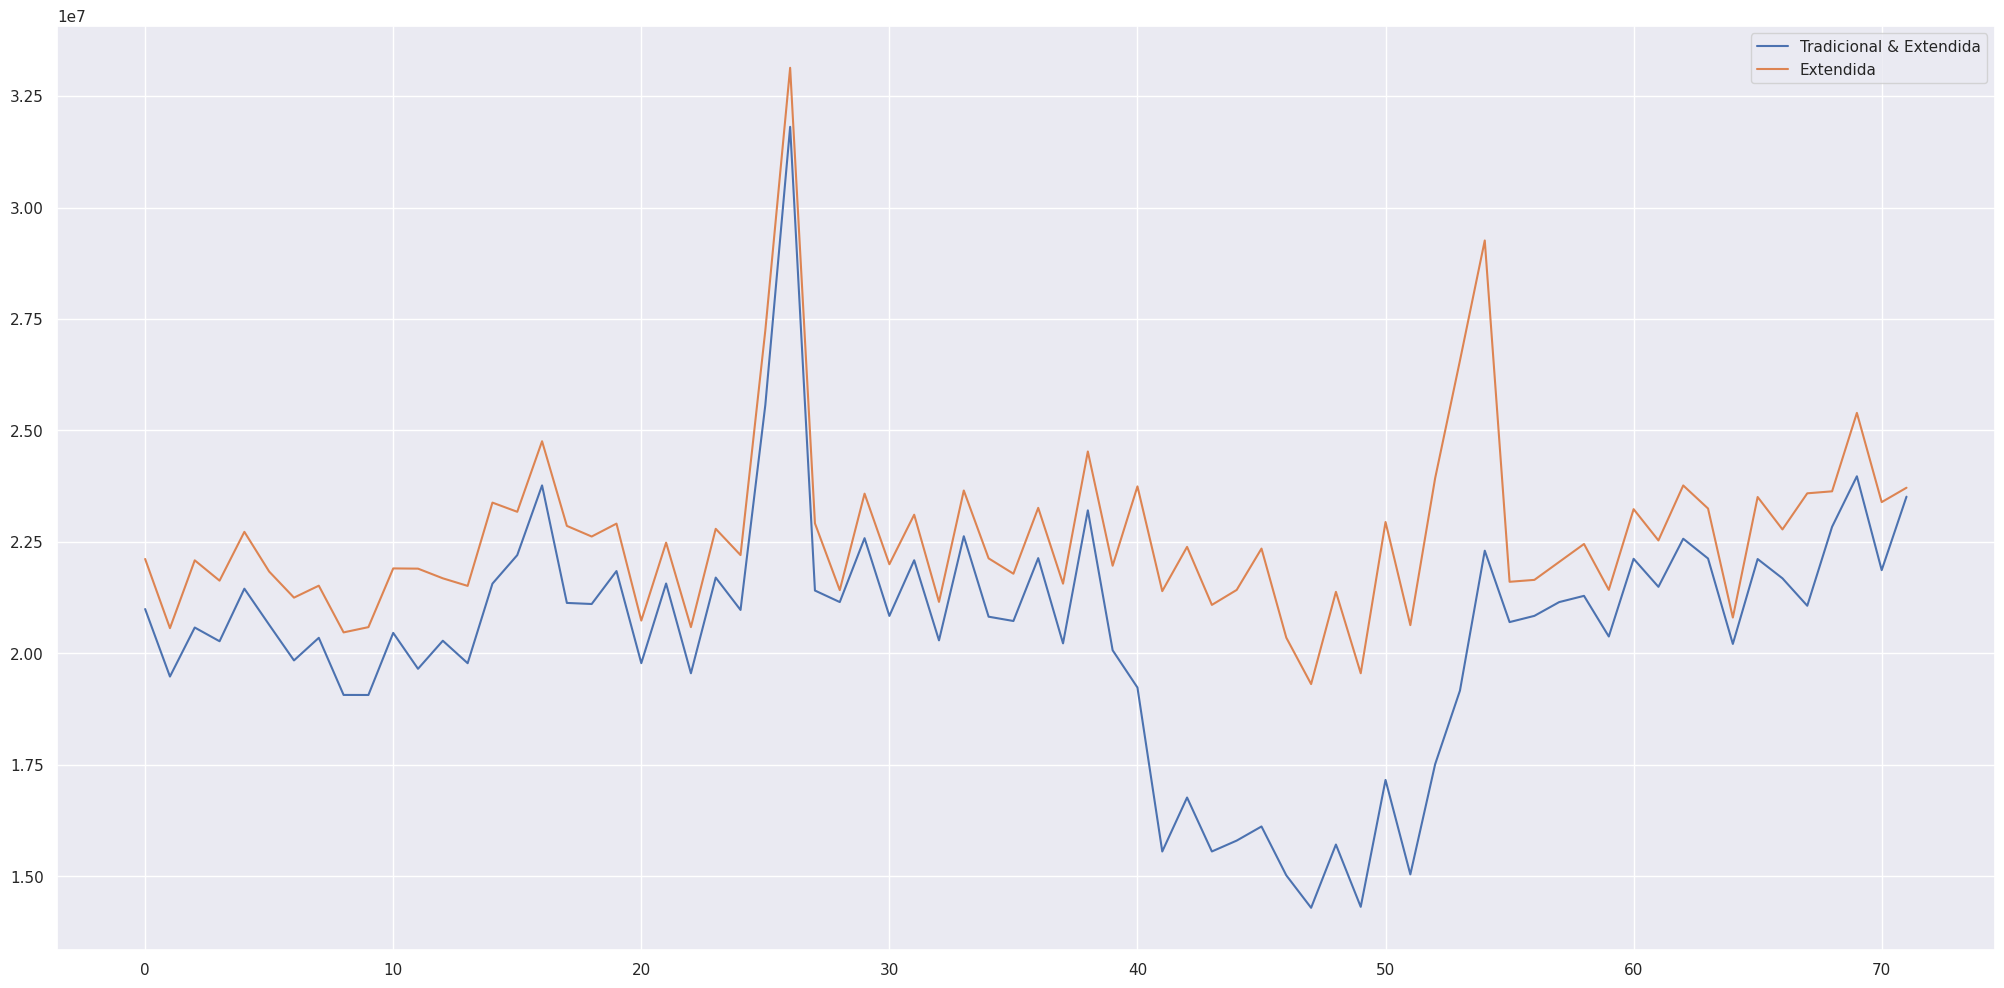

In [34]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
***FALSA.*** Lojas abertas DURANTE O FERIADO DE NATAL vendem MENOS.

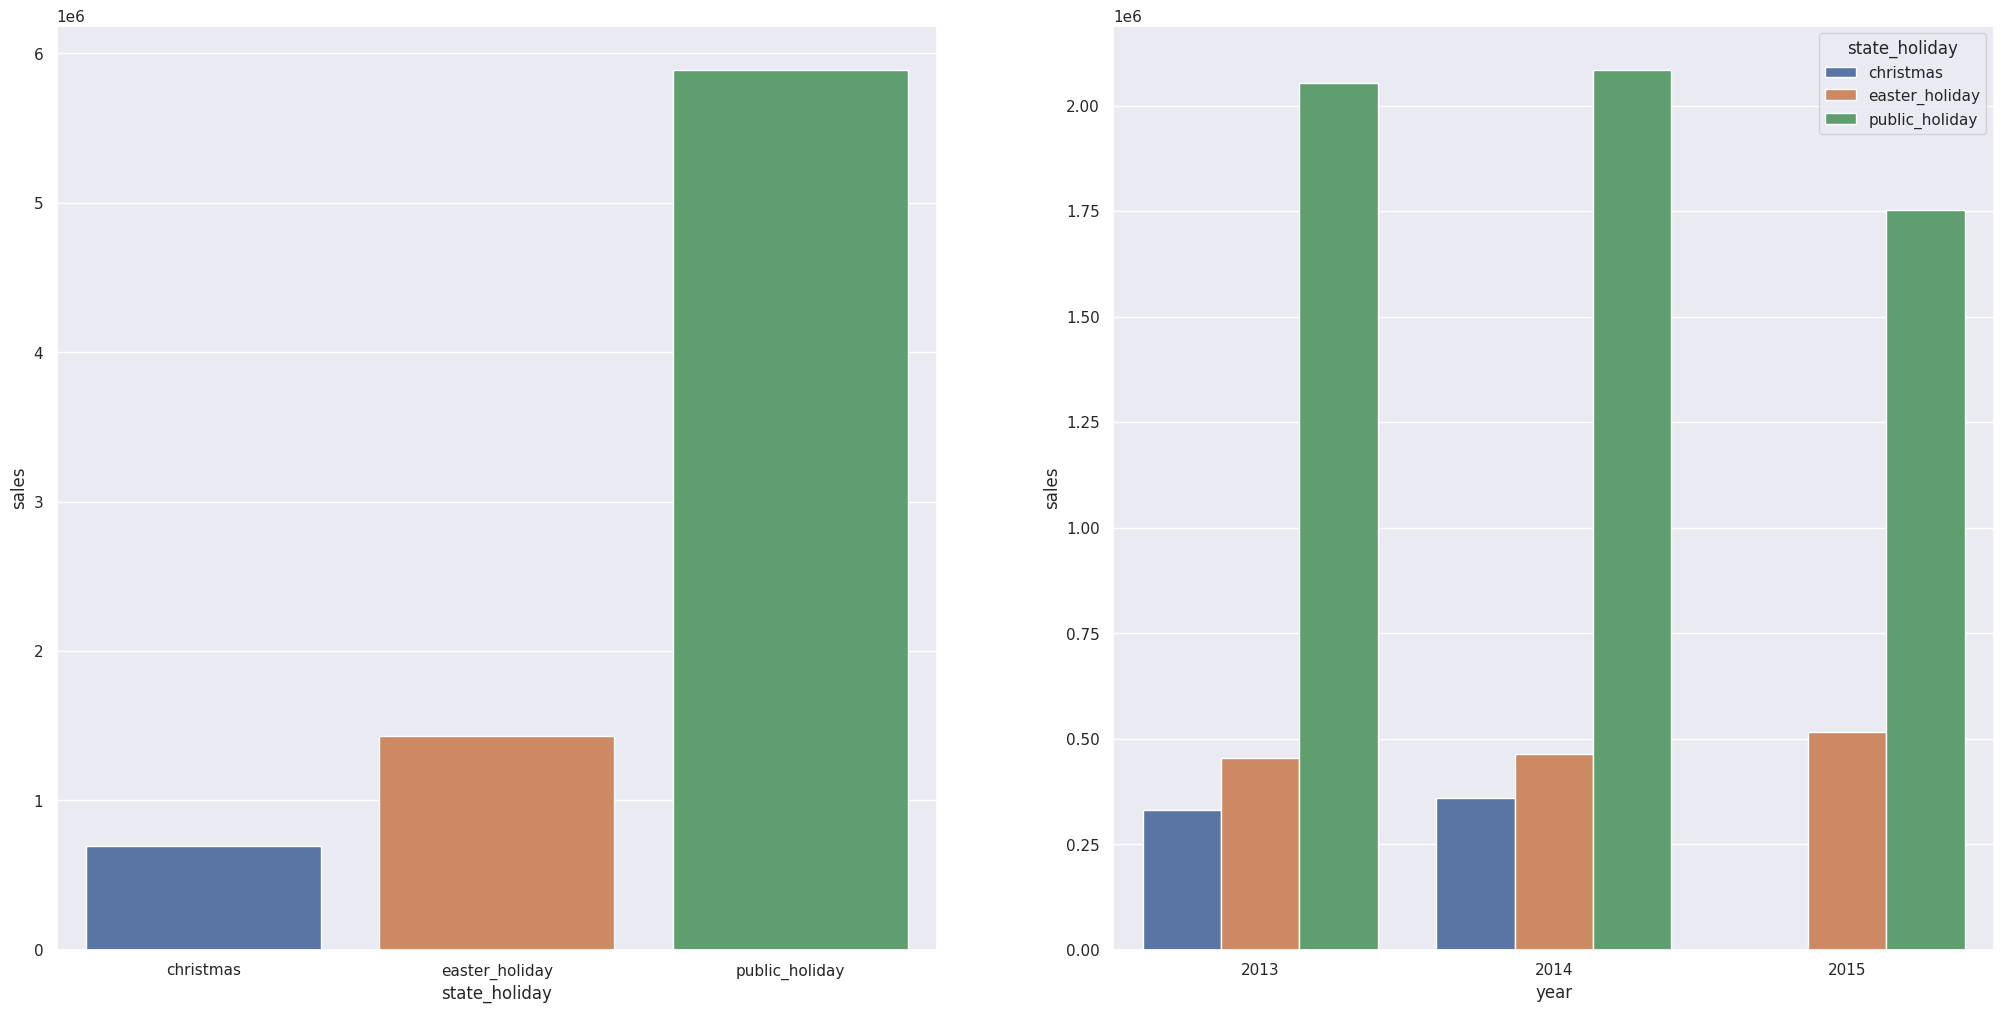

In [35]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', data=aux2, hue='state_holiday');

### H8. Lojas deveriam vender mais ao longo dos anos.
***FALSA.*** Lojas vendem MENOS ao LONGO DOS ANOS.

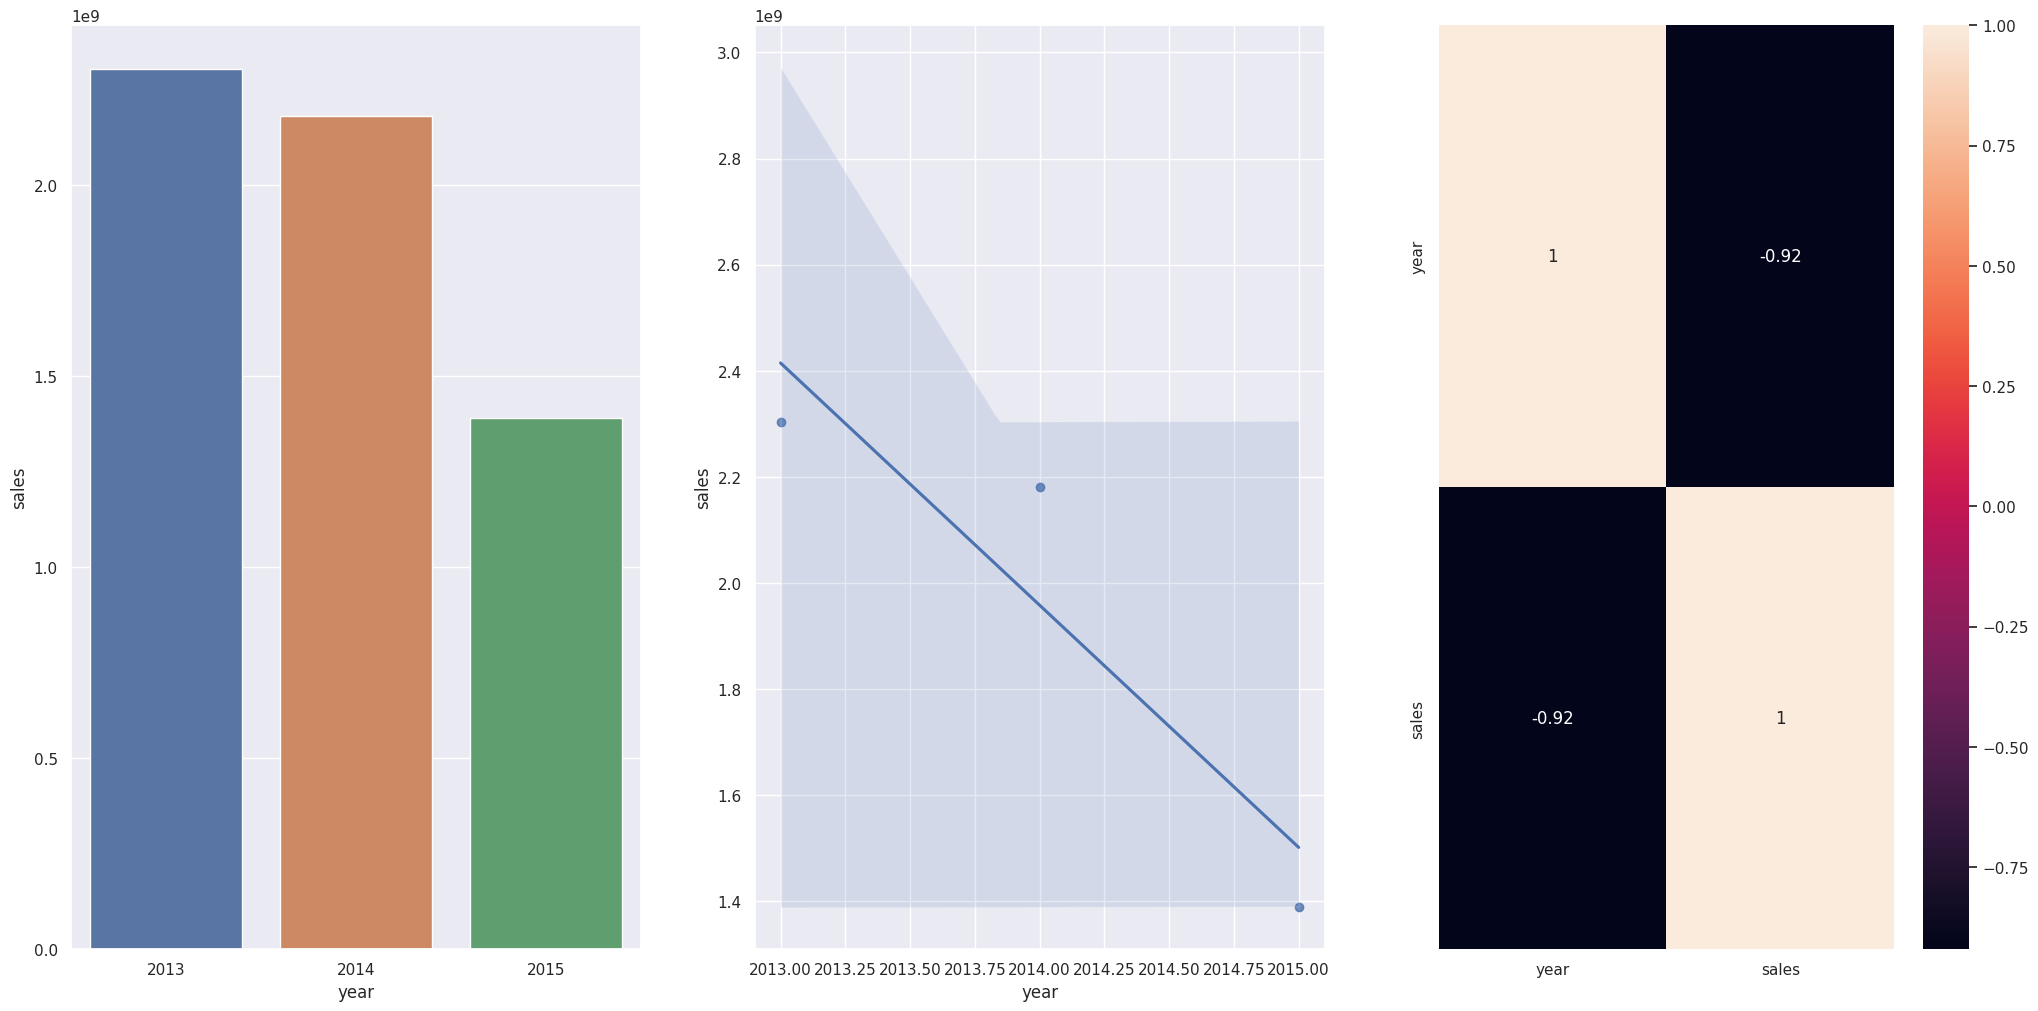

In [36]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3 , 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
***FALSA***. Lojas vendem MENOS no SEGUNDO SEMESTRE DO ANO.

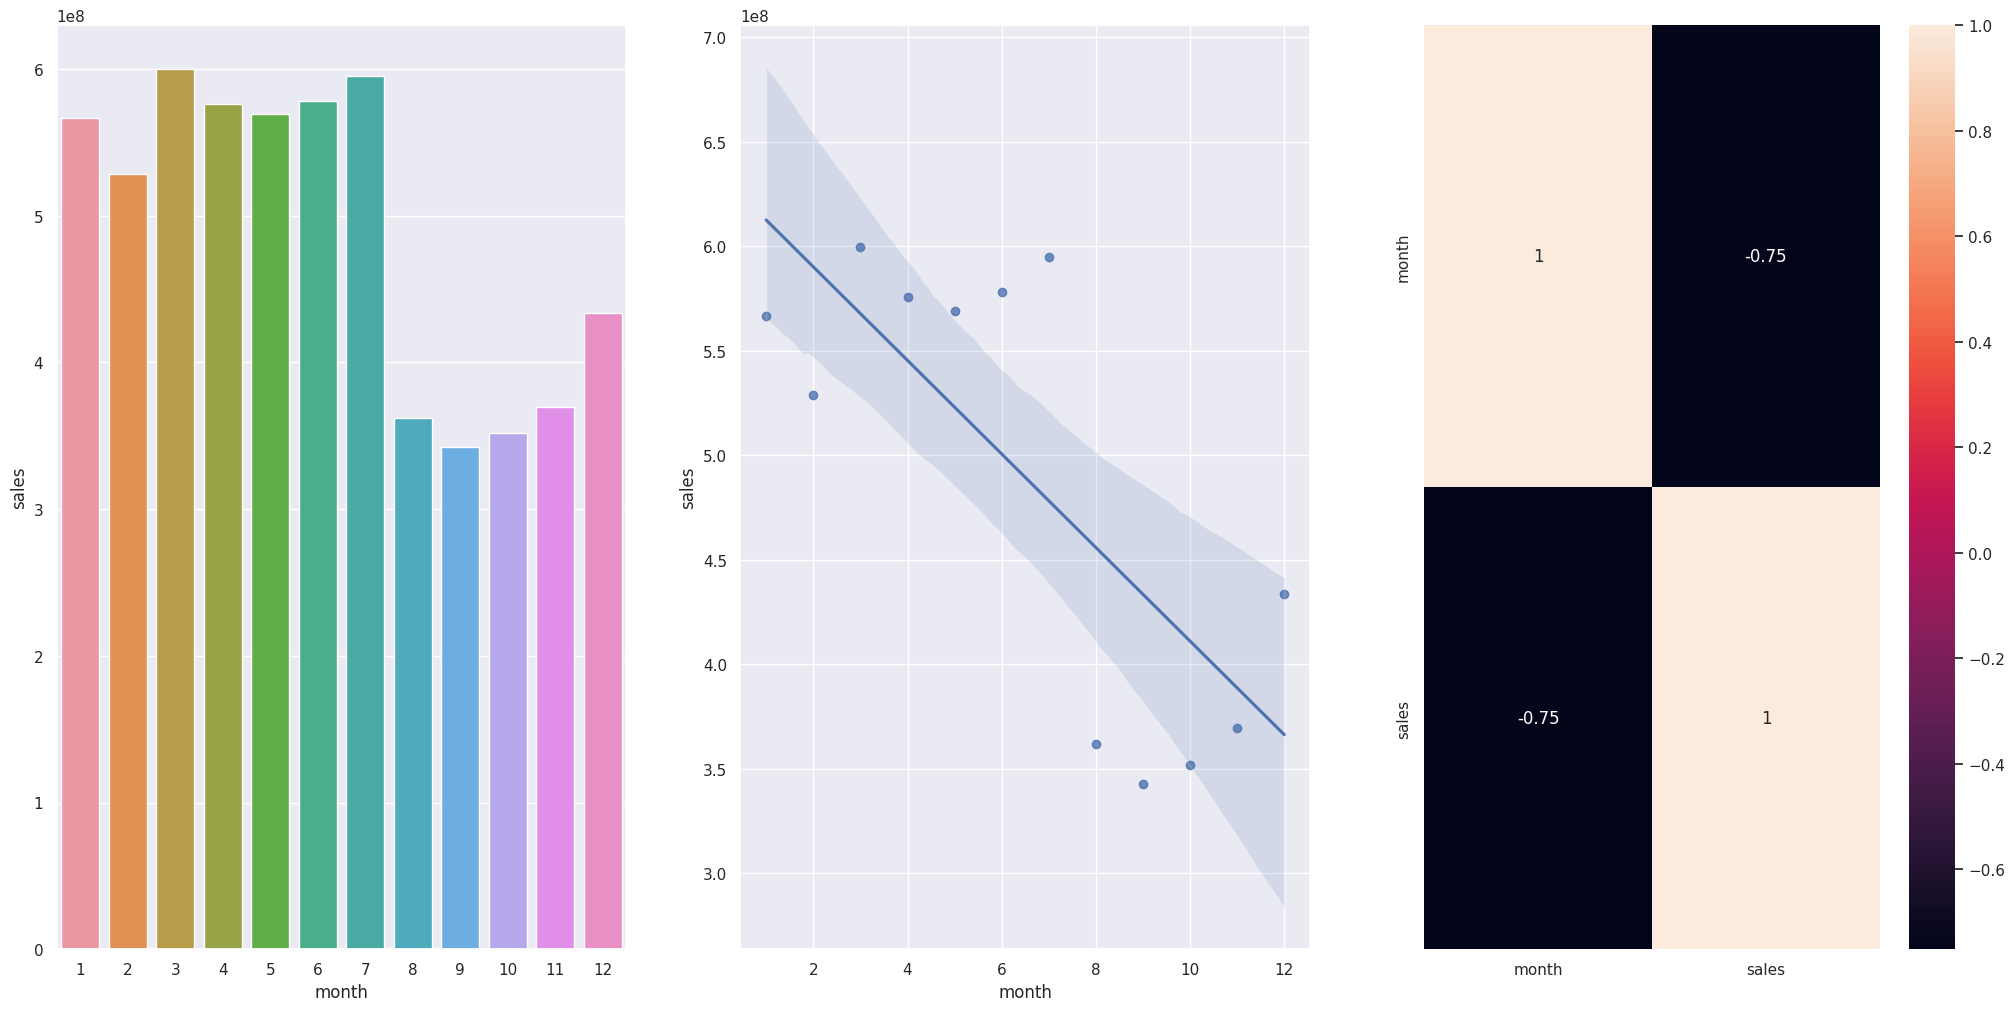

In [37]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3 , 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
***VERDADEIRA.*** Lojas vendem MAIS depois do dia 10 DE CADA MÊS.

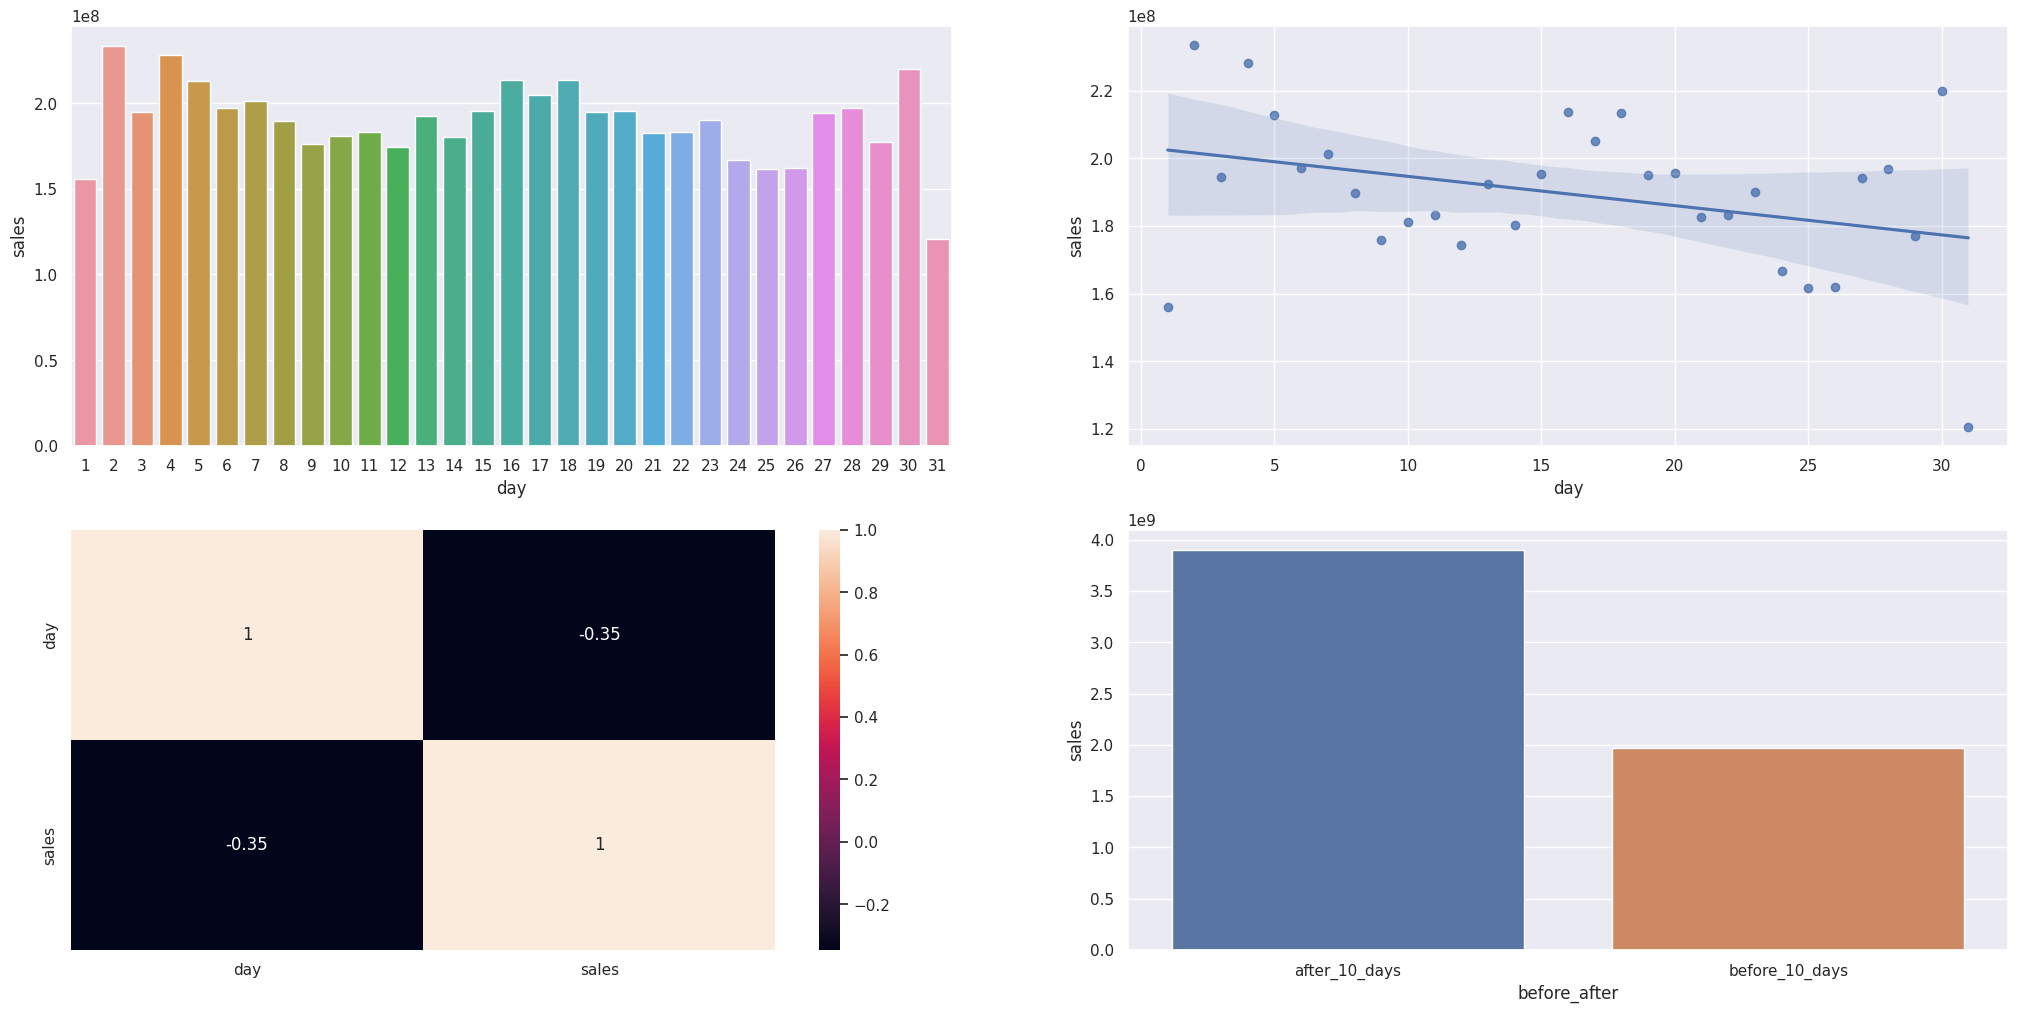

In [38]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2 , 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

plt.subplot(2, 2 , 4)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
***VERDADEIRA.*** Lojas vendem MENOS aos FINAIS DE SEMANA.

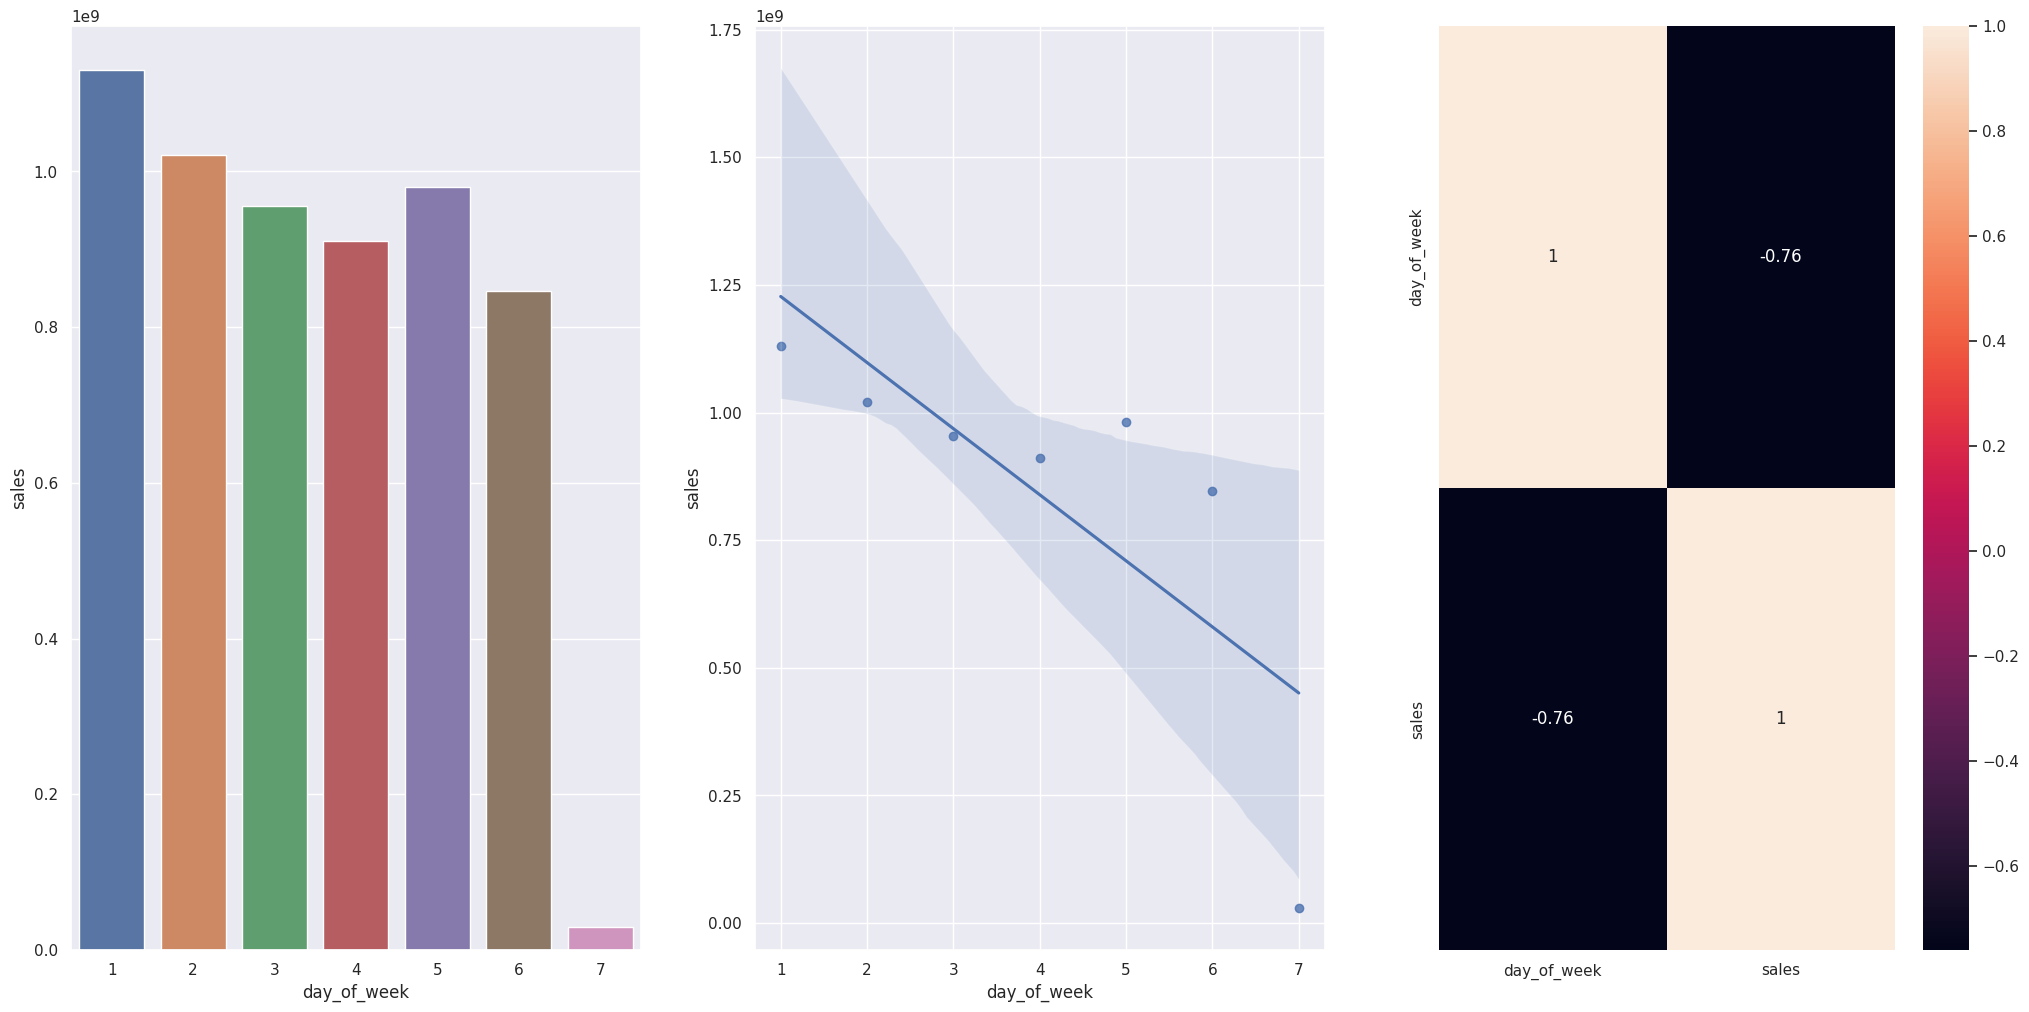

In [39]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3 , 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
***VERDADEIRA.*** Lojas vendem MENOS durante os FERIADOS ESCOLARES, exceto os meses de julho e agosto.

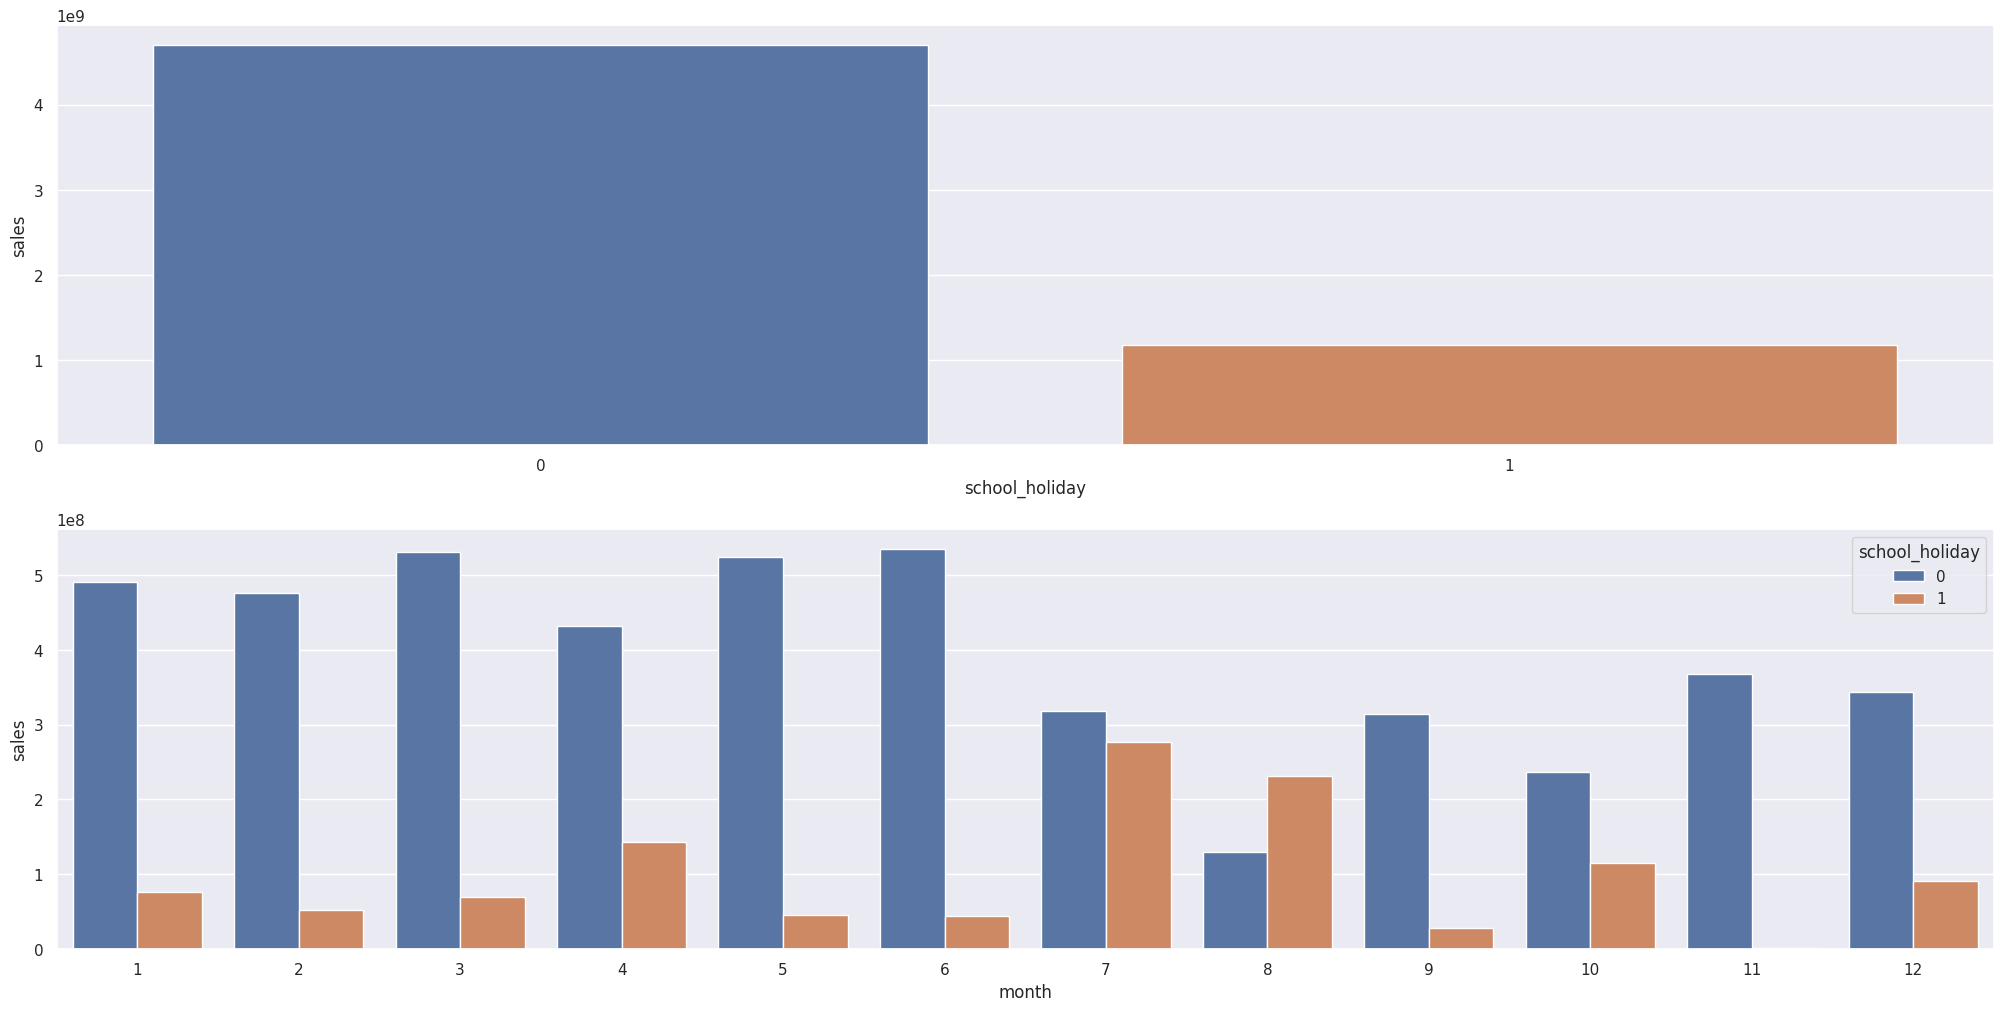

In [40]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipóteses

| Hipóteses | Conclusão | Relevância |
|-------|-------|-----|
H1| Falsa | Baixa
H2| Falsa | Baixa
H3| Falsa | Baixa
H4| Falsa | Baixa
H5| - | -
H6| Falsa | Baixa
H7| Falsa | Média
H8| Falsa | Alta
H9| Falsa | Alta
H10| Falsa | Alta
H11| Falsa | Alta
H12| Falsa | Baixa

## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

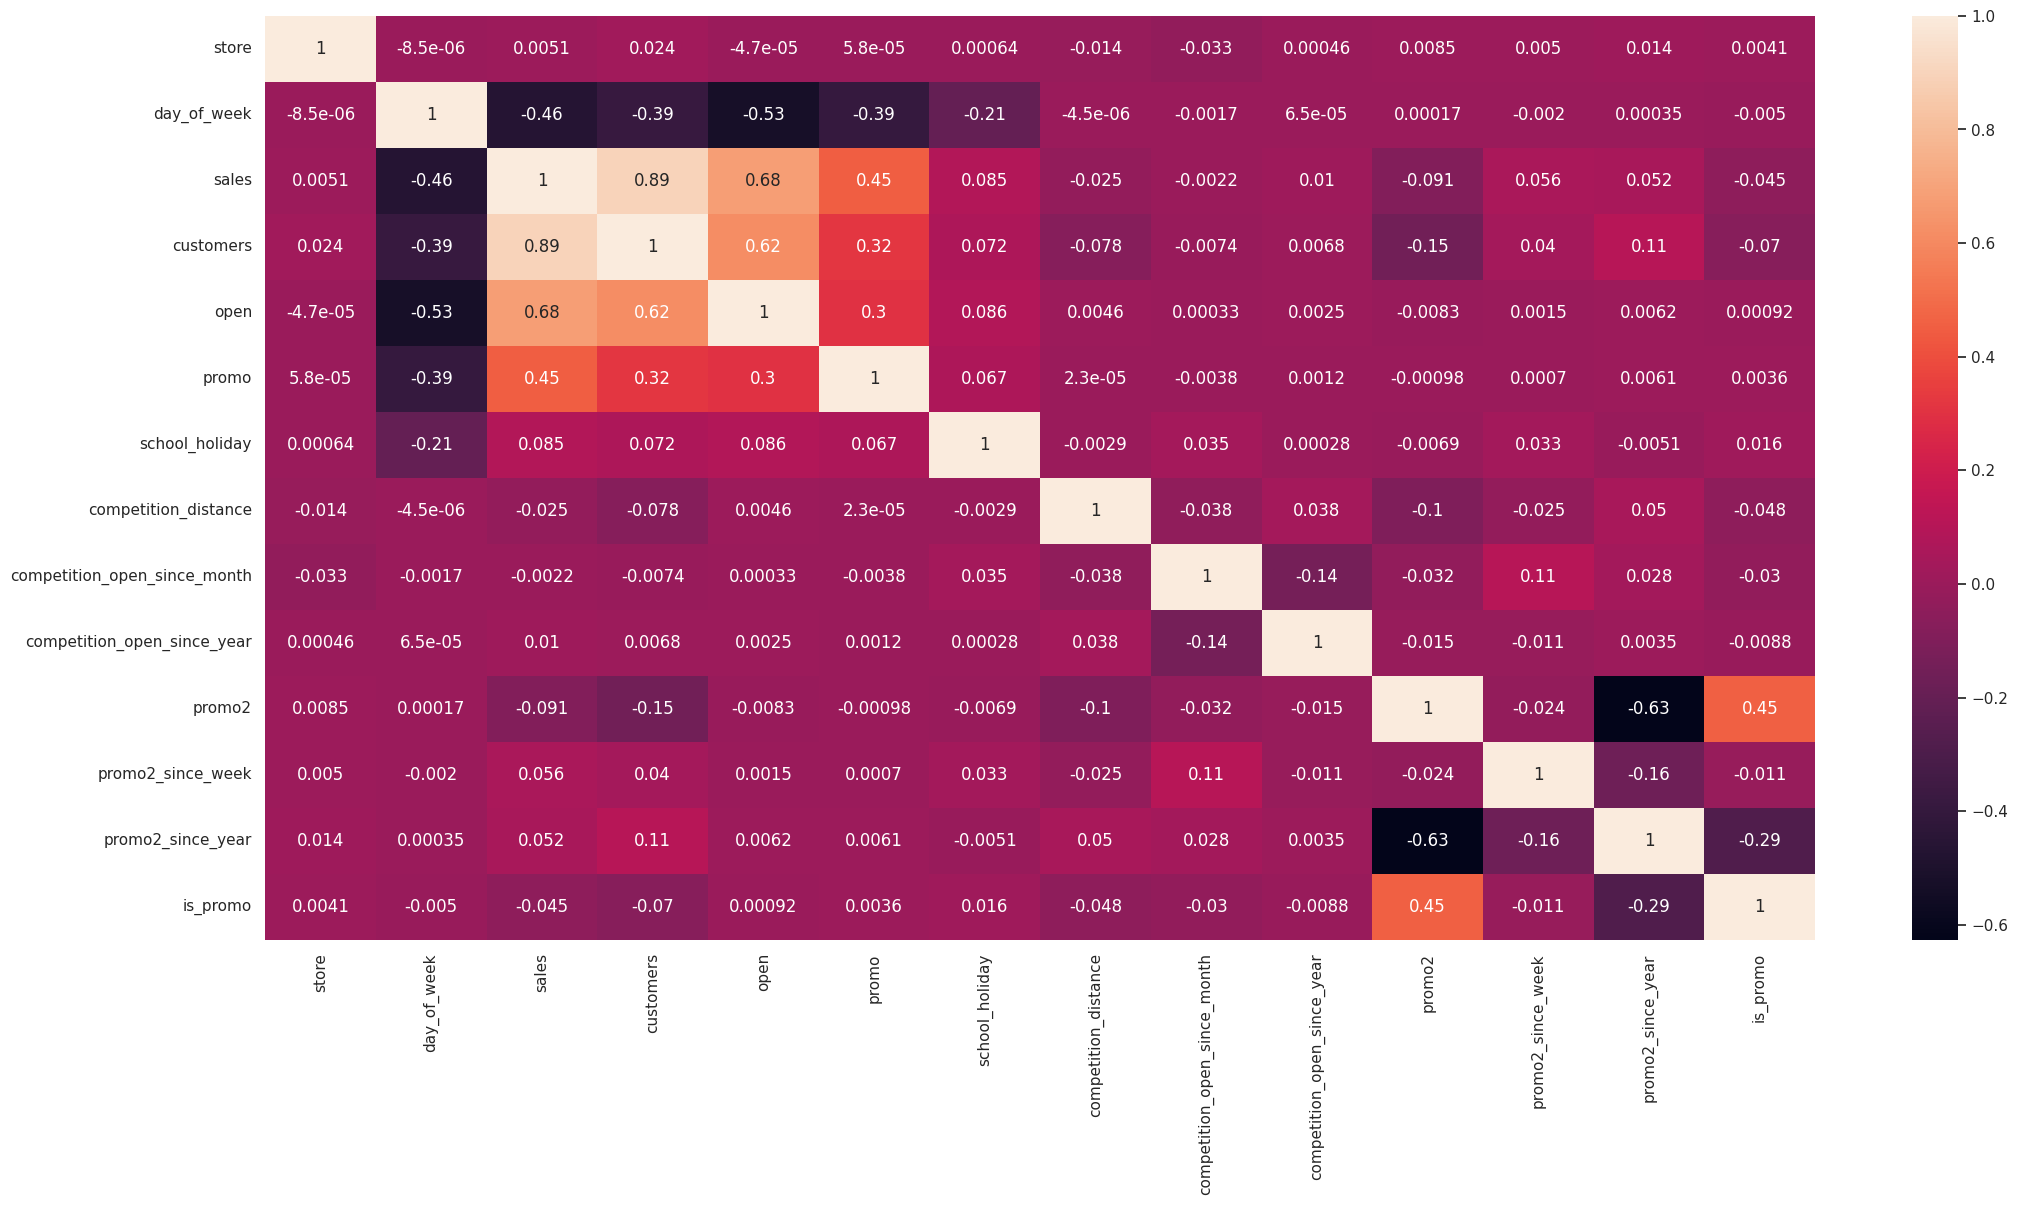

In [41]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

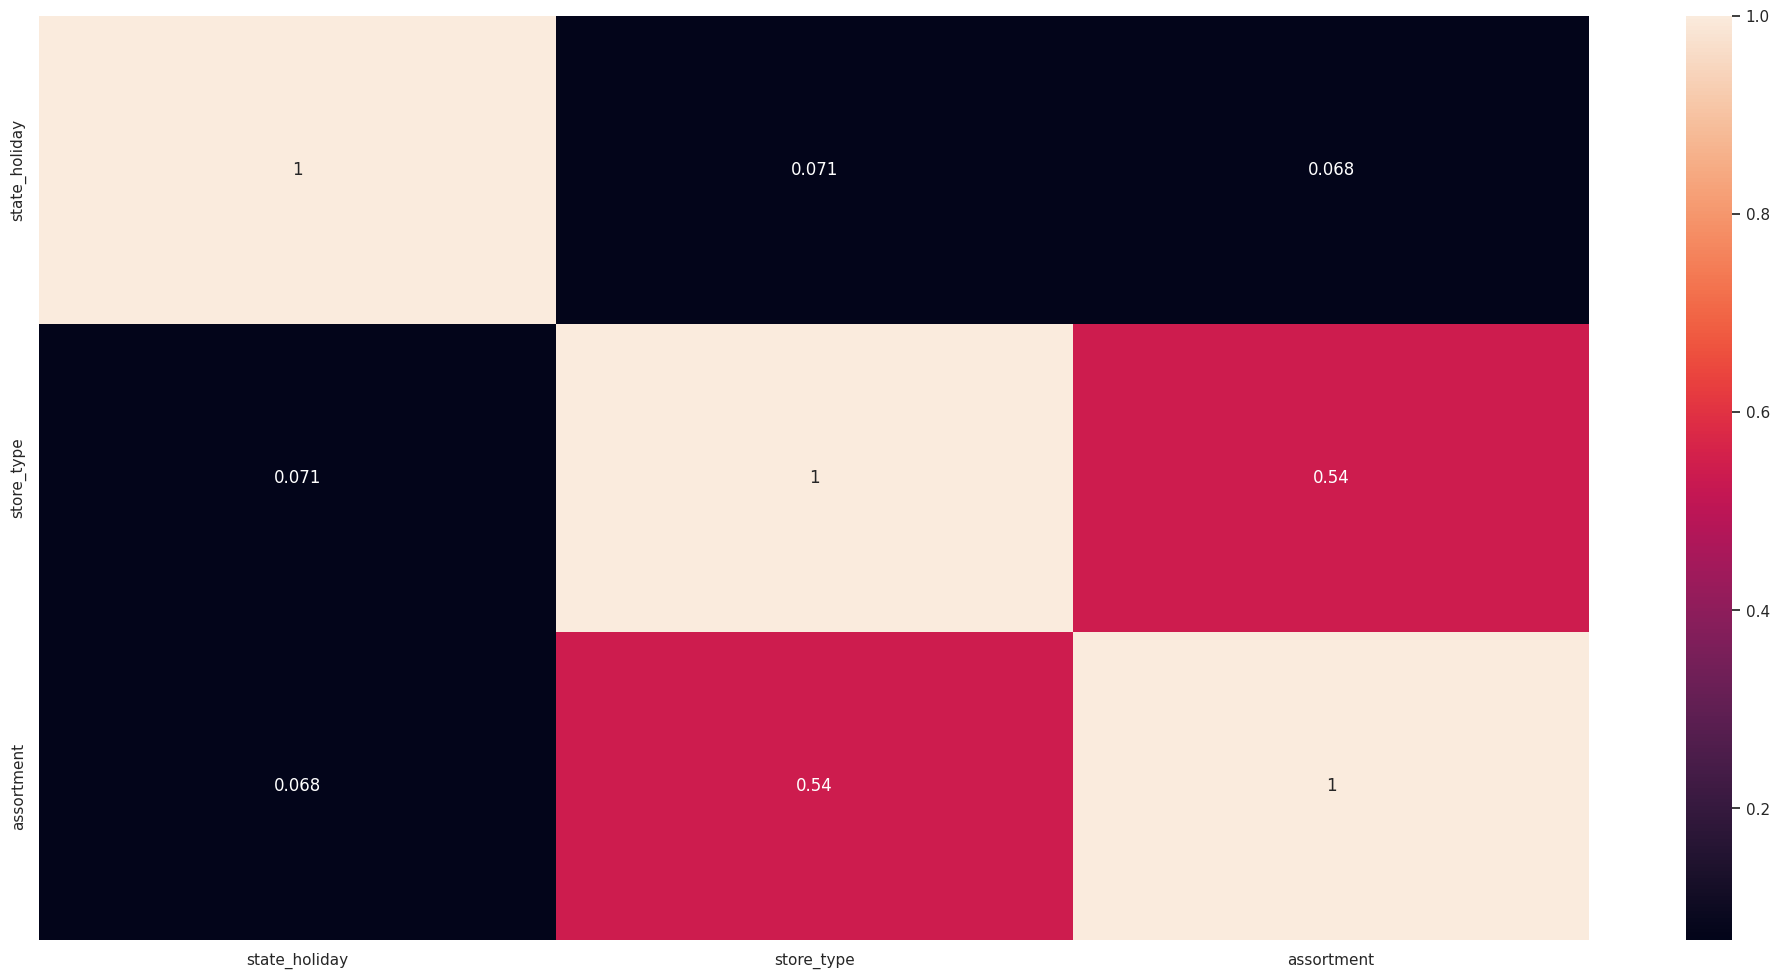

In [42]:
# only categorical data
a = df4.select_dtypes(include='object')

# calculating cramers v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
            'store_type': [a4, a5, a6],
            'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0 PASSO 05 - DATA PREPARATION

In [57]:
df5 = df4.copy()
df_cv = df4.copy()

## Split for Boruta/Final Model

In [58]:
# training dataset
X_train = df5[df5['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df5[df5['date'] >= '2015-06-19'] # 6 weeks to simulate the prediction
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 5.1 Normalização

## 5.2 Rescaling

In [59]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
X_train['competition_distance'] = rs.fit_transform(X_train[['competition_distance']].values)
X_test['competition_distance'] = rs.transform(X_test[['competition_distance']].values)

# competition time month
X_train['competition_time_month'] = rs.fit_transform(X_train[['competition_time_month']].values)
X_test['competition_time_month'] = rs.transform(X_test[['competition_time_month']].values)

# promo time week
X_train['promo_time_week'] = mms.fit_transform(X_train[['promo_time_week']].values)
X_test['promo_time_week'] = mms.transform(X_test[['promo_time_week']].values)

# year
X_train['year'] = mms.fit_transform(X_train[['year']].values)
X_test['year'] = mms.transform(X_test[['year']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [60]:
# state_holiday - One Hot Encoding
ohe = OneHotEncoder()        
transformed = ohe.fit_transform(X_train[['state_holiday']])
X_train[ohe.categories_[0]] = transformed.toarray()

# tranform encoding for test data
transformed_valid = ohe.transform(X_test[['state_holiday']])
X_test[ohe.categories_[0]] = transformed_valid.toarray()

# store_type - Label Encoding
le = LabelEncoder()
X_train['store_type'] = le.fit_transform(X_train['store'])
X_test['store_type'] = le.transform(X_test['store'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
X_train['assortment'] = X_train['assortment'].map(assortment_dict)
X_test['assortment'] = X_test['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [61]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

### 5.3.1 Nature Transformation

In [62]:
# day of week
X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
X_train['month_sin'] = X_train['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
X_train['month_cos'] = X_train['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

X_test['month_sin'] = X_test['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
X_test['month_cos'] = X_test['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
X_train['day_sin'] = X_train['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
X_train['day_cos'] = X_train['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

X_test['day_sin'] = X_test['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
X_test['day_cos'] = X_test['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0 PASSO 06 - FEATURE SELECTION

## 6.1 Droping columns for boruta

In [63]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week', 'state_holiday']
X_train = X_train.drop(cols_drop, axis=1)
X_test = X_test.drop(cols_drop, axis=1)

## 6.2 Boruta as Feature Selector

In [ ]:
# # training and test dataset for Boruta
# X_train_b = X_train.drop(['date', 'sales'], axis=1).values
# y_train_b = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_b, y_train_b)

### 6.2.1 Best Features from Boruta

In [ ]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

## 6.3 Manual Feature Selection

In [33]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 PASSO 07 - MACHINE LEARNING MODELLING

In [34]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 Average Model 

In [35]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model - Cross Validation

In [41]:
# model
lr = LinearRegression()

# cross validation
lr_result_cv = cross_validation(df_cv, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

End of Data Preparation
End of Data Preparation
End of Data Preparation
End of Data Preparation
End of Data Preparation


,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1905.59+/-100.99,0.29+/-0.01,2724.02+/-162.77


## 7.3 Linear Regression Regularized Model Lasso - Cross Validation

In [44]:
# model alpha 0.01
lrr = Lasso(alpha=0.01)

# cross validation
lrr_result_cv = cross_validation(df_cv, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

End of Data Preparation
Iteration Done
End of Data Preparation
Iteration Done
End of Data Preparation
Iteration Done
End of Data Preparation
Iteration Done
End of Data Preparation
Iteration Done


,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1922.33+/-109.47,0.29+/-0.01,2745.56+/-195.84


## 7.4 Random Forest Regressor - Cross Validation

In [44]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# cross validation
rf_result_cv = cross_validation(df_cv, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

## 7.5 XGBoost Regressor - Cross Validation

In [48]:
# model
model_xgb = xgb.XGBRegressor(objetive='reg:squarederror',
                             n_estimators=100,
                             eta=0.1,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.8,
                             random_state=42,
                             n_jobs=-1)

# cross validation
xgb_result_cv = cross_validation(df_cv, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

## 7.6 LightGBM Regressor - Cross Validation

In [ ]:
# model
model_lgbm = lgbm.LGBMRegressor(n_estimators=300)

# cross validation
lgbm_result_cv = cross_validation(df_cv, 5, 'LGBM', model_lgbm, verbose=True)
lgbm_result_cv

## 7.7 Compare Model's Performance

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv, lgbm_result_cv])
modelling_result_cv.sort_values('RMSE CV')

# 8.0 PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [46]:
param = {'n_estimators': [400, 650, 800],
          'learning_rate': [0.01, 0.05, 0.1],
          'max_depth': [7, 9, 13],
          'num_leaves': [30, 55, 75, 85],
          'min_child_samples': [20, 80, 120, 200]}

max_eval = 10

In [47]:
final_result = pd.DataFrame()

for i in range(max_eval):
    #choose values for parameters randomly
    hp = {k: sample(v, 1)[0] for k, v in param.items()}
    print(i)
    print(hp)
    
    # model
    model_lgbm = lgbm.LGBMRegressor(n_estimators=hp['n_estimators'],
                                    learning_rate=hp['learning_rate'],
                                    max_depth=hp['max_depth'],
                                    num_leaves=hp['num_leaves'],
                                    min_child_samples=hp['min_child_samples'],
                                    n_jobs=-1)

    # performance
    result = cross_validation(df_cv, 5, 'LightGBM Regressor', model_lgbm, verbose=1)
    final_result = pd.concat([final_result, result])

0
{'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 13, 'num_leaves': 55, 'min_child_samples': 20}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
1
{'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 75, 'min_child_samples': 120}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
2
{'n_estimators': 800, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 30, 'min_child_samples': 120}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
3
{'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 55, 'min_child_samples': 80}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
4
{'n_estimators': 650, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 30, 'min_child_samples': 80}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
5
{'n_estimators': 800, 'learning_rate': 0.

,Model name,MAE CV,MAPE CV,RMSE CV
0,LightGBM Regressor,1328.76+/-88.79,0.19+/-0.0,1905.55+/-135.66
0,LightGBM Regressor,870.91+/-95.87,0.13+/-0.01,1250.96+/-136.59
0,LightGBM Regressor,1009.21+/-76.36,0.15+/-0.01,1451.0+/-111.78
0,LightGBM Regressor,1432.35+/-92.4,0.21+/-0.0,2086.56+/-145.13
0,LightGBM Regressor,1596.56+/-100.82,0.23+/-0.0,2301.98+/-159.65
0,LightGBM Regressor,765.33+/-83.32,0.11+/-0.01,1099.72+/-118.82
0,LightGBM Regressor,943.78+/-83.76,0.14+/-0.01,1359.96+/-125.1
0,LightGBM Regressor,903.95+/-85.59,0.13+/-0.01,1293.22+/-124.14
0,LightGBM Regressor,825.48+/-98.07,0.12+/-0.01,1181.51+/-138.62
0,LightGBM Regressor,1623.66+/-109.64,0.24+/-0.0,2347.15+/-181.18


In [50]:
final_result

,Model name,MAE CV,MAPE CV,RMSE CV
0,LightGBM Regressor,1328.76+/-88.79,0.19+/-0.0,1905.55+/-135.66
0,LightGBM Regressor,870.91+/-95.87,0.13+/-0.01,1250.96+/-136.59
0,LightGBM Regressor,1009.21+/-76.36,0.15+/-0.01,1451.0+/-111.78
0,LightGBM Regressor,1432.35+/-92.4,0.21+/-0.0,2086.56+/-145.13
0,LightGBM Regressor,1596.56+/-100.82,0.23+/-0.0,2301.98+/-159.65
0,LightGBM Regressor,765.33+/-83.32,0.11+/-0.01,1099.72+/-118.82
0,LightGBM Regressor,943.78+/-83.76,0.14+/-0.01,1359.96+/-125.1
0,LightGBM Regressor,903.95+/-85.59,0.13+/-0.01,1293.22+/-124.14
0,LightGBM Regressor,825.48+/-98.07,0.12+/-0.01,1181.51+/-138.62
0,LightGBM Regressor,1623.66+/-109.64,0.24+/-0.0,2347.15+/-181.18


## 8.2 Final Model

In [53]:
param_tuned = {'n_estimators': 800,
               'learning_rate': 0.1,
               'max_depth': 13,
               'num_leaves': 85,
               'min_child_samples': 20}

In [54]:
# model
model_lgbm_tuned = lgbm.LGBMRegressor(n_estimators=param_tuned['n_estimators'],
                                      learning_rate=param_tuned['learning_rate'],
                                      max_depth=param_tuned['max_depth'],
                                      num_leaves=param_tuned['num_leaves'],
                                      min_child_samples=param_tuned['min_child_samples'],
                                      n_jobs=-1).fit(x_train, y_train)

# prediction
yhat_lgbm_tuned = model_lgbm_tuned.predict(x_test)

# performance
lgbm_result_tuned = ml_error('LightGBM Regressor', np.expm1(y_test), np.expm1(yhat_lgbm_tuned)) 
lgbm_result_tuned

,Model Name,MAE,MAPE,RMSE
0,LightGBM Regressor,657.30852,0.096696,955.729333


In [55]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_lgbm_tuned))
mpe

-0.007710504081305582

# 9.0 PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [66]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['predictions'] = np.expm1(yhat_lgbm_tuned)

## 9.1 Business Performance

In [67]:
# sum of predictions
df91 = df9[['store', 'predictions', 'sales']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'predictions', 'sales']].groupby('store').apply(lambda x: mean_absolute_error(
                                                                x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

df9_aux2 = df9[['store', 'predictions', 'sales']].groupby('store').apply(lambda x:mean_absolute_percentage_error(
                                                                x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

<AxesSubplot: xlabel='store', ylabel='MAPE'>

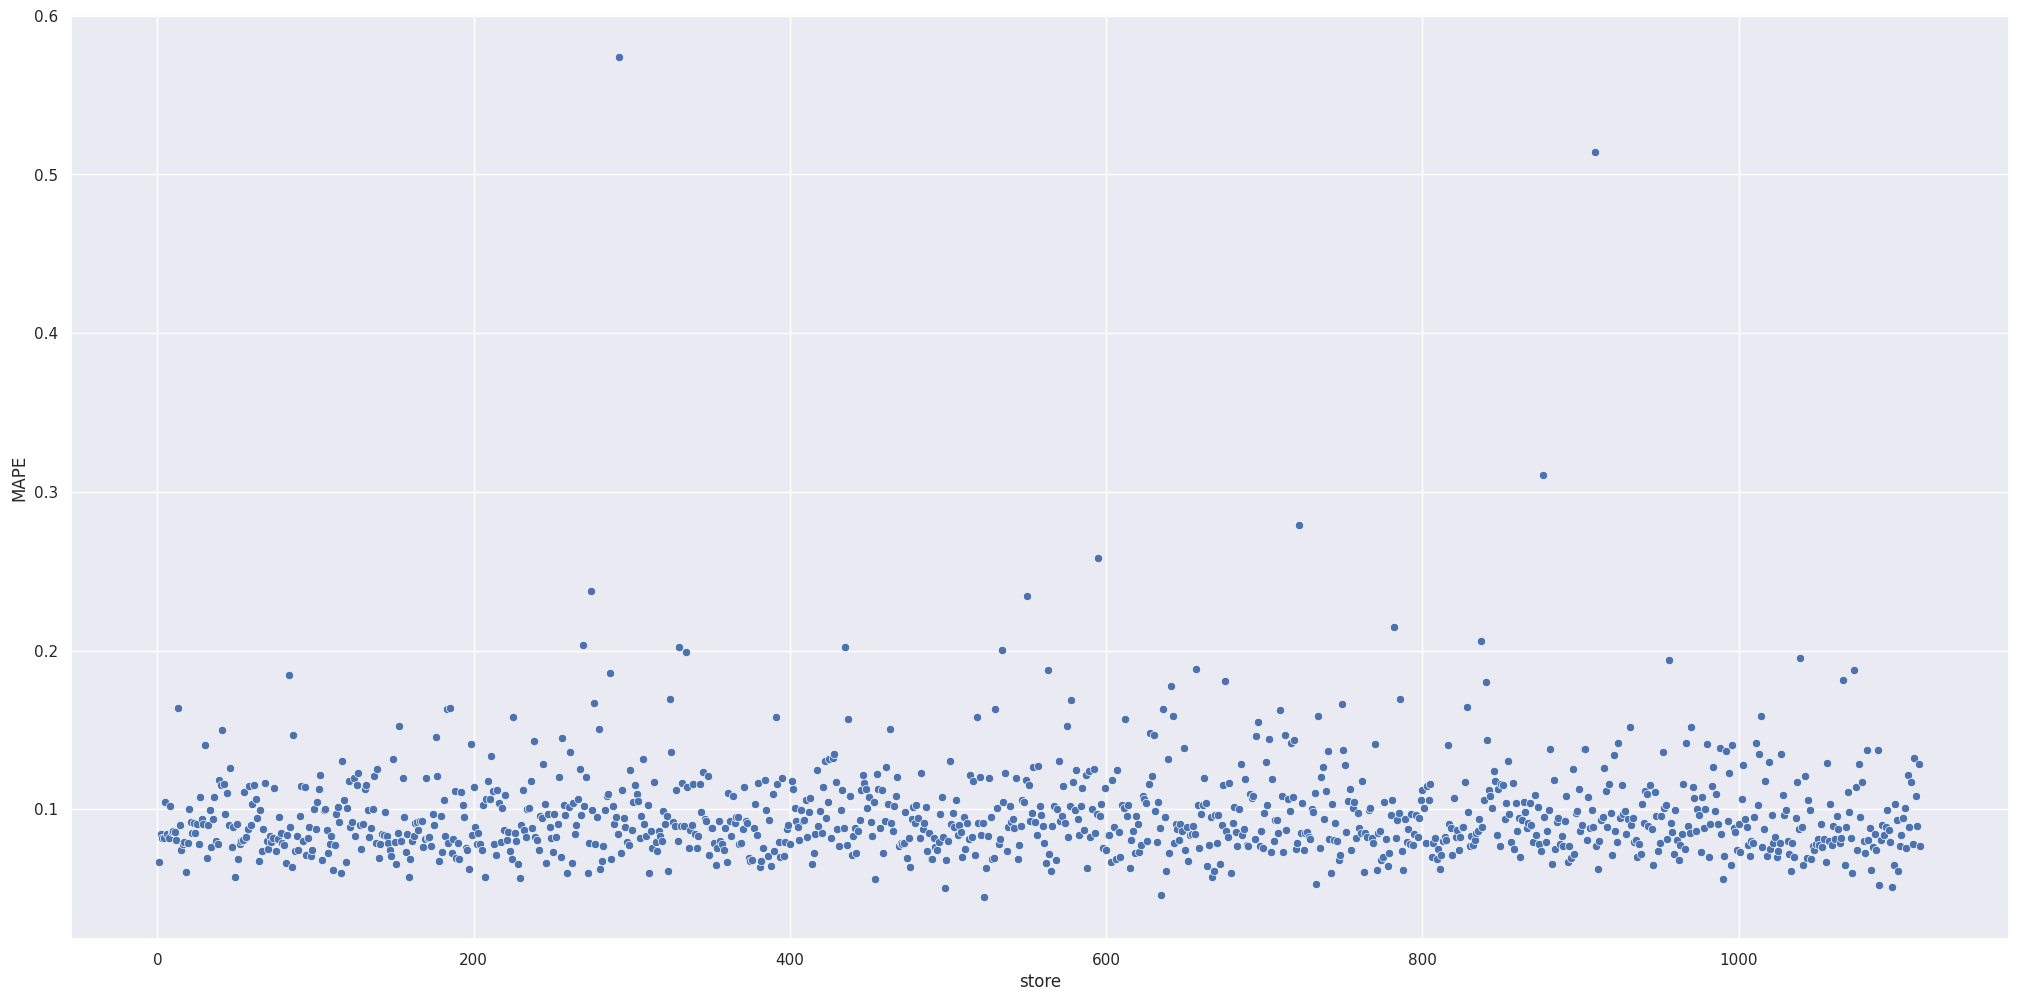

In [68]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [69]:
df93 = df92[['predictions',
             'worst_scenario',
             'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})

df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$286,351,257.77"
1,worst_scenario,"R$285,614,249.52"
2,best_scenario,"R$287,088,266.02"


## 9.3 Machine Learning Performance

In [70]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

<AxesSubplot: xlabel='predictions', ylabel='error'>

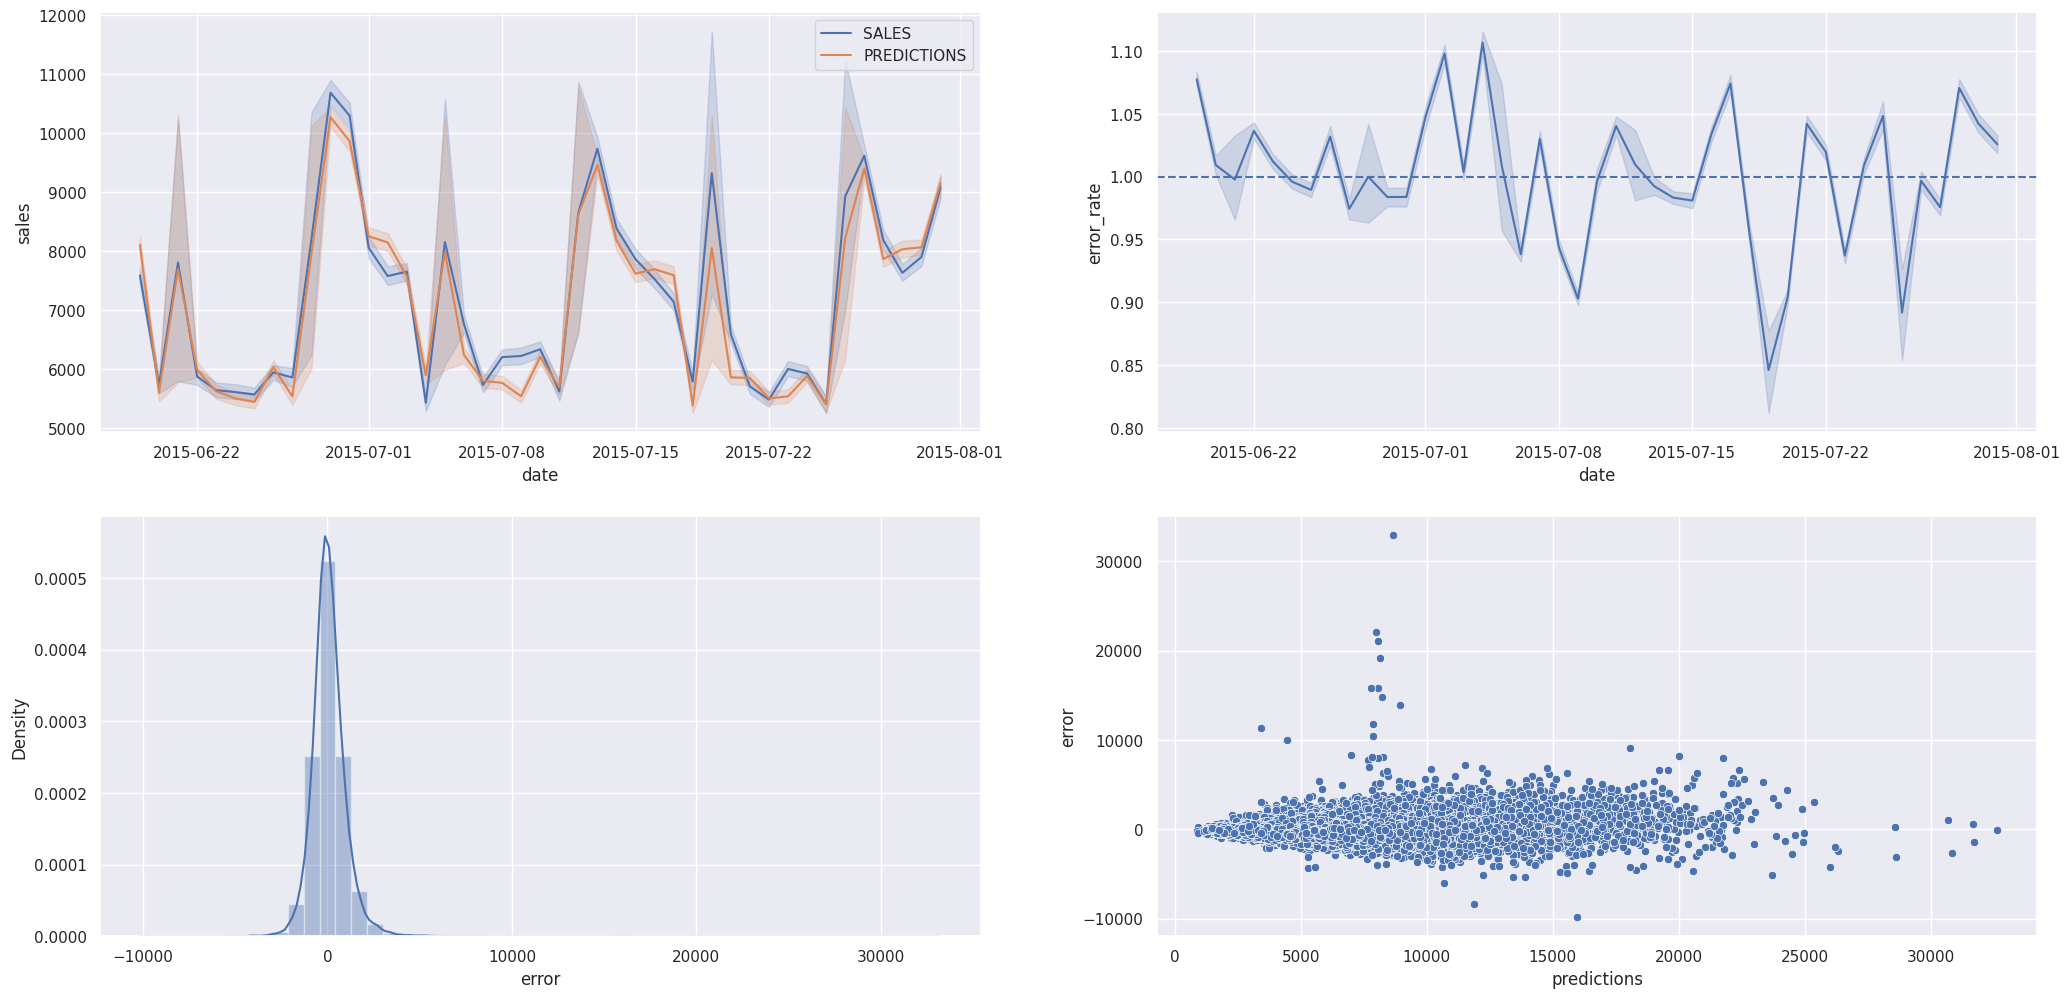

In [71]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])

# 10.0 PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [72]:
# Save Trained Model
pickle.dump(model_lgbm_tuned, open('../model/model_rossmann.pkl', 'wb'))

In [76]:
# Save parameters for Production
rs.fit(df_cv[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

rs.fit(df_cv[['competition_time_month']].values)
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

mms.fit(df_cv[['promo_time_week']].values)
pickle.dump(mms, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

mms.fit(df_cv[['year']].values)
pickle.dump(mms, open('../parameter/year_scaler.pkl', 'wb'))

ohe.fit(df_cv[['state_holiday']])
pickle.dump(ohe, open('../parameter/state_holiday_encoder.pkl', 'wb'))

le.fit(df_cv['store'])
pickle.dump(le, open('../parameter/store_type_encoder.pkl', 'wb'))

## 10.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.home_path='/home/matheus/repos/Rossmann-sales-forecast/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
        
    def data_cleaning(self, df1):

        ## 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new
        
        # change date type
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x)
                                                                        else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if 
                                                        math.isnan(x['competition_open_since_month']) else
                                                        x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if 
                                                        math.isnan(x['competition_open_since_year']) else
                                                        x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if 
                                                        math.isnan(x['promo2_since_week']) else
                                                        x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if 
                                                        math.isnan(x['promo2_since_year']) else
                                                        x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8:'Aug', 9:'Sept', 10: 
                     'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in 
                                      x['promo_interval'].split(',') else 0, axis = 1)

        ## 1.6 Change Types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                         month=x['competition_open_since_month'], 
                                                                         day=1), axis=1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: 
                                                                                            x.days).astype(int) 

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - 
                                                      datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'
                                                    else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                          else 'easter_holiday' if x == 'b' 
                                                          else 'christmas' if x == 'c' else 'regular_day')

        # 3.0 PASSO 3 - FILTRAGEM DE VARIÁVEIS 
        ## 3.1 Filtragem das Linhas 

        df2 = df2[df2['open'] != 0]

        ## 3.2 Seleção das Colunas 

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):
        ## 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)

        ## 5.3 Transformação
        ### 5.3.1 Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.1 Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        cols_selected = ['store', 'promo','store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week','day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                         'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask                import Flask, Response, request
from rossmann.Rossmann.py import Rossmann

# loading model
model = pickle.load(open('/home/matheus/repos/Rossmann-sales-forecast/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict):# unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
        # Instantiate Rossmann class
        pipeline = Rossmann()    
    
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature enginnering
        df2 = pipeline.feature_enginnering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

## 10.3 API Tester

In [ ]:
import requests

In [ ]:
# loading test dataset
df10 = pd.read_csv('data/test.csv')

In [ ]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 12, 22, 23, 25, 26, 27])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [ ]:
# convert DataFrame to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-forecast.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d1.head()

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell ${:,.2f} in the next 6 weeks'.format(
        d2.loc[i, 'store'],
        d2.loc[i, 'prediction']))